# Notebook final

## Estructura de archivos y carpetas


* **Code** *Códigos + matlab*
    * **External** *Continene JIDT*
    * **MatlabIsing** *Contiene el código de Matlab para ajuste de modelo ising*
        * **Rasters** *Contiene los rasters para usar en matlab*
        * **Models** *Contiene los modelos generados por matlab*
    * *DataDetails.json - Archivo de conjuntos*
    * *JITDWrapper.py - Wrapper para usar JITD de external*
* **Data** *Carpeta de matrices previamente guardadas*
    * **PreComputed** *Archivos calculados*
        * **MI** *Matrices de información mutua*
        * **H** *Vectores de entropía*
        * *Archivo de distancias de campos receptivos*
        * *Archivo de spikes de 4 retinas bajo 5 estímulos*
* **Documents**
    * *Propuesta - Propuesta de la solución que se propone para lograr lo esperado*
    * *Plan de Implementación - Avances progresivos en el código y propuestas*
    * *Fundamentos - Algunas detalles matemáticos de lo que se hace en el código*
            
**Estructura de nombres de archivos**
    
Se definen los nombres tanto de rasters como de modelos en matlab de la siguiente manera:

`E_C_T_N_R_P_F_S_.mat`

Luego de cada letra sigue un número o numeros que representan lo siguiente

|Letra|Número|
|---|---|
|E|Número de Retina|
|C|Estímulo presentado|
|T|Tiempo de binning|
|N|Neurona a predecir|
|R|Tipo de ranking|
|P|Porcentaje de raster|
|F|Número de neuronas|
|S|Número de sample|

Para los casos de criterio de ranking y sección de raster, el detalle es el siguiente

|Nro|Ranking|Nro|Sección|
|---|---|---|---|
|0|Aleatorio|0|100%|
|1|Aleatorio Incremental|1|70%|
|2|Información Mutua| | 
|3|Distancia de campo receptivo| | 
|4|Correlación| | 

Para la estructura de las predicciones se utiliza el siguiente identificador dentro del archivo `N_.pkl`

`(R,P,F,S,PP)`

Donde las letras `R,P,F,S` corresponden a las definiciones anteriores, y el `PP` Corresponde a lo que fue predicho.

|Nro|Sección|
|---|---|
|0|100%|
|1|70%|
|2|30%| 



## Secciones del código

1. **Preliminares**
    1. Imports
    2. Definición de parametros fijos
    3. Carga/Cómputo de variables almacenadas de uso constante
2. **Selección de neuronas**
    1. Carga de archivo de conjunto de neuronas **(*)**
    2. Computa los conjuntos de neuronas
        1. Aleatorio (5 x 10/20/50/100/120/150)
        2. Aleatorio Incremental (5 x 10/20/50/100/120/150)
        3. En base a información Mutua (1 x 1:10/20/50/100/120/150)
        4. En base a Correlación (1 x 1:10/20/50/100/120/150)
        5. En base a Distancia de Campos receptivos (1 x 1:10/20/50/100/120/150)
3. **Creación de Modelos (\*\*)**
    1. Exportar rasters a formato MATLAB
        1. En formato Completo/Train 70%
    2. Exportar las lineas de código para ejecutar sobre MATLAB
    3. Ejecutar MATLAB **(Externo)**
4. **Cálculo de predicciónes**
    1. Función de predicción de raster en base a modelo
    2. Llamadas a la función de preducción y guardado de resultados
5. **Cálculo de métricas**
    1. Función de cálculo de métricas en base a resultados
    2. Llamadas a función de cálculo de métricas y guardado de resultados
6. **Gráficos**
    1. Visualizar predicciones v/s datos originales
    2. Obtener graficos de las métricas según distintos parámetros
    3. Obtener los espacios de las métricas
7. **Adicionales**
    1. Eliminación de rasters **(\*\*\*)**
    
**(*)** = Sólo si el archivo existe, o de lo contrario se generará uno en el punto 2.

**(\*\*)** = Es necesario hacer esto sólo una vez.

**(\*\*\*)** = Los rasters de matlab sólo se utilizan en el punto 3 y luego se trabaja con los modelos, su generación puede ser muy pesada. En caso de necesitarse nuevamente su generación es rápida y se basa en el archivo de conjuntos del punto 2.

In [127]:
### 1 - Preliminares

#### Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import os
import pickle
from matplotlib.ticker import ScalarFormatter
from ipywidgets import interact,interact_manual,IntSlider
from scipy.io import loadmat,savemat
from scipy.ndimage.filters import gaussian_filter1d
from scipy import sparse
from json import loads,dumps
from jpype import *
from JITDWrapper import *
from sklearn.manifold import MDS
from scipy.spatial import ConvexHull

%matplotlib inline

#### Parámetros Fijos
EXP = 0 # 0 1 2 3
COND = 3 # 0.issa 1.ifsa 2.wn 3.nm 4.ffsa 5. fssa
TBASE = 0.02 #0.001 = 1ms
RASTER = dataLoader(EXP,COND,TBASE)[0]
cubed = np.split(RASTER[:,:-63],41,axis=1) #1506 * 41 + 63 = T
SINGLERASTER = np.sum(cubed,axis=0)
INTERVAL = 50 # para SpRate
N,T = RASTER.shape
J = 5
NsR = [10,20,50,100,120,N-1]
Ns = [4,5,6,7,8,9,10,20,50,100,120,N-1]
TP = 31 #Neurona a predecir
#### Cargas iniciales

D = loadmat("../Data/rfOverlap.mat")["rfDist"][0]#[0]
MI = MutualInformation(EXP,COND,TBASE)
MI = MI+MI.T
CC = np.corrcoef(RASTER[:50],RASTER[50:])**2-np.diag(np.ones(N))

Dcc = np.zeros((N,N)) #phsth correlation
for x in range(N):
    for y in range(N):
        Dcc[x][y]= np.corrcoef(SINGLERASTER[x],SINGLERASTER[y])[0,1]**2

#Embeddings
Dembed = MDS(2,dissimilarity="precomputed")
Dpoints = Dembed.fit(D).embedding_
MIembed = MDS(2,dissimilarity="precomputed")
MIpoints = MIembed.fit(MI+MI.T-np.diag(MI+MI.T)).embedding_
CCembed = MDS(2,dissimilarity="precomputed")
CCpoints = CCembed.fit(CC).embedding_


def loadOnOff():
    #0=Null, 1=ON, 2=OFF, 3=On-Off
    onoff = loadmat("../Data/OnOff/on_off_list.mat")["on_off_clases"]
    return dict([(c,np.where(onoff==c)[0]) for c in range(4)])

onoff = loadOnOff()

Returning saved sparse matrix E0_C3_T0.02
Returning PreComputed MIMatrix E0_C3_T0.02


In [92]:
onoffind = {}
for n in range(151):
    for c in range(4):
        if n in onoff[c]:
            onoffind[n]=c

<BarContainer object of 1506 artists>

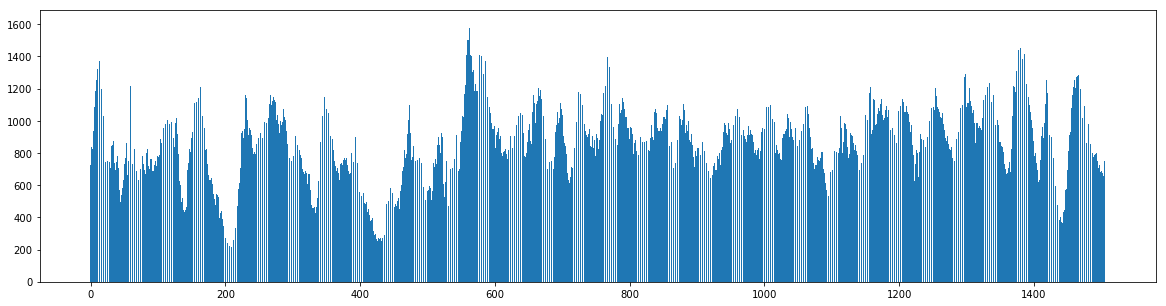

In [81]:
plt.figure(figsize=(20,5))
plt.bar(range(1506),np.sum(np.sum(cubed,axis=0),axis=0))

In [84]:
### 2 - Selección de neuronas
#### Carga de archivo
def cargarDataset(TP):
    if "N{0}.json".format(TP) in os.listdir("Datasets"):
        with open("Datasets/N{0}.json".format(TP)) as DD:
            dataset = loads(DD.readline())
        print("Carga de archivo existente para neurona {0}".format(TP))

    #### Creación de Archivo
    else:
        #fixed = int(np.random.choice(range(N)))
        fixed = TP
        free = np.array(list(set(range(N))-{fixed}))
        mienum = sorted([(x[1],x[0]) for x in enumerate(MI[fixed])],reverse=1) #mayor a menor
        miids = list([x[1] for x in mienum])
        miids.remove(fixed)
        cenum = sorted([(x[1],x[0]) for x in enumerate(CC[fixed])],reverse=1)
        cids = list([x[1] for x in cenum])[:-1]
        denum = sorted([(x[1],x[0]) for x in enumerate(D[fixed])])
        dids = list([x[1] for x in denum])[1:]
        dataset = {"fixed":fixed,
                   0:dict([(n,[sorted(np.random.choice(free,n,False).tolist()) for j in range(J)]) for n in NsR]),
                   1:{},
                   2:dict([(n,[miids[:n]]) for n in Ns]),
                   3:dict([(n,[dids[:n]]) for n in Ns]),
                   4:dict([(n,[cids[:n]]) for n in Ns])} 
        newsets=[np.random.choice(list(set(range(N))-{fixed}),N-1,False).tolist() for j in range(J)]
        for n in NsR:
            dataset[1][n]=[]
            for j in range(J):
                dataset[1][n].append(newsets[j][:n])
        with open("Datasets/N{0}.json".format(TP),"w") as DD:
            DD.write(dumps(dataset))
    return dataset
    
#dataset = {#tipo_selección:{#neuronas:[sample0,sample1,...]}} sampleN = [id0,id1,id2,...]


In [96]:
s=0
for s in range(100):
    minidat = cargarDataset(s)
    sel = list(map(lambda x:onoffind[x],minidat["2"]["20"][0])) #on off on-off 
    print(onoffind[s],np.array([sel.count(1),sel.count(2),sel.count(3),sel.count(0)])*100/20)


Carga de archivo existente para neurona 0
2 [20. 10. 70.  0.]
Carga de archivo existente para neurona 1
3 [25. 15. 60.  0.]
Carga de archivo existente para neurona 2
1 [20. 15. 65.  0.]
Carga de archivo existente para neurona 3
3 [20. 15. 65.  0.]
Carga de archivo existente para neurona 4
3 [10. 10. 70. 10.]
Carga de archivo existente para neurona 5
3 [10. 15. 65. 10.]
Carga de archivo existente para neurona 6
3 [20. 15. 55. 10.]
Carga de archivo existente para neurona 7
3 [10. 20. 65.  5.]
Carga de archivo existente para neurona 8
3 [10. 15. 70.  5.]
Carga de archivo existente para neurona 9
2 [ 5. 20. 70.  5.]
Carga de archivo existente para neurona 10
3 [25. 15. 60.  0.]
Carga de archivo existente para neurona 11
2 [25.  5. 65.  5.]
Carga de archivo existente para neurona 12
3 [15. 30. 55.  0.]
Carga de archivo existente para neurona 13
1 [25. 15. 60.  0.]
Carga de archivo existente para neurona 14
1 [25. 15. 60.  0.]
Carga de archivo existente para neurona 15
3 [20. 15. 65.  0.]
Ca

In [3]:
### 3 - Creación de modelos
#### Código para exportar a archivos MATLAB
def saveRasters(neuron):
    dataset=cargarDataset(neuron)
    for rank in [0,1,2,3,4]: #tipo de ranking
        if rank in [0,1]:
            flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
        else:
            flist,slist = [4,5,6,7,8,9,10,20,50,100,120,150],[0]
            #flist,slist = [1,2,3],[0]#,10,20,50,100,120,150],[0]
        for f in flist: #neuronas fijadas
            for s in slist: #samples
                savemat("MatlabIsing/Rasters/E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,neuron,rank,0,f,s),
                        {"binnedSpikes":RASTER[[neuron]+dataset[str(rank)][str(f)][s],:]})
                #savemat("MatlabIsing/Rasters/E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,neuron,rank,1,f,s),
                #        {"binnedSpikes":RASTER[[neuron]+dataset[str(rank)][str(f)][s],:int(T*0.7)]})
                #print ("Guardado MatlabIsing/Rasters/E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,neuron,rank,0,f,s))

#for localTP in range(85,115): #pend
#    saveRasters(localTP)
#    print(localTP,"OK")

In [4]:
#### Código para generar las lineas ejecutables en MATLAB
def modelsMatlabLines(neuron):
    filelist = []
    for rank in [0,1,2,3,4]: #tipo de ranking
        if rank in [0,1]:
            flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
        else:
            flist,slist = [4,5,6,7,8,9,10,20,50,100,120,150],[0]
            #flist,slist = [1,2,3],[0]#,10,20,50,100,120,150],[0]
        for f in flist: #neuronas fijadas
            for s in slist: #samples
                filelist.append("E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}".format(EXP,COND,TBASE,neuron,rank,0,f,s))
                #filelist.append("E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}".format(EXP,COND,TBASE,neuron,rank,1,f,s))
                #print ("Ajustar('{0}','{1}','{2}');".format('Rasters','Models',
                #                                            "E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,neuron,rank,0,f,s)))
                #print ("Ajustar('{0}','{1}','{2}');".format('Rasters','Models',
                #                                            "E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,neuron,rank,1,f,s)))
    return filelist

#matlines =  []
#for nn in range(85,115):
#    matlines = matlines+modelsMatlabLines(nn)
#matliness  = modelsMatlabLines(15)

In [72]:
# Del total de nuevos modelos cuantos faltan
foldercont = os.listdir("MatlabIsing/Models/")
rematlines=[f for f in matlines if f+".mat" not in foldercont]
print(len(matlines),len(rematlines))
#print(rematlines)

NameError: name 'matlines' is not defined

In [73]:
# Evaluar cuantos rasters tienen sus modelos listos
rastercont = os.listdir("MatlabIsing/Rasters/")
modelcont = os.listdir("MatlabIsing/Models/")
print (len(set(rastercont)-set(modelcont)),len(modelcont),len(rastercont))


251 15673 251


In [ ]:
### Correr los modelos en matlab
def run_matlab(filename,back=0):
    print("""matlab -nodisplay -nosplash -nodesktop -r "cd('MatlabIsing');Ajustar('Rasters','Models','{}.mat');exit()" """.format(filename)+["","&"][back])
    return
    os.system("""matlab -nodisplay -nosplash -nodesktop -r "cd('MatlabIsing');Ajustar('Rasters','Models','{}.mat');exit()" """.format(filename)+["","&"][back])

    
sortedlines = sorted(rematlines,key=lambda s: int(s[s.index("F")+1:s.index("S")]))
for sub in range(len(sortedlines))[::5]:
    sl =  sortedlines[sub:sub+5]
    print(sl)
    run_matlab(sl[0],1)
    run_matlab(sl[1],1)
    run_matlab(sl[2],1)
    run_matlab(sl[3],1)
    run_matlab(sl[4],0)


In [74]:
# Evaluar para cada neurona qué tipos de modelos tiene listos
# Recordar el xxxxxN__RxxP_S_ -> #Deben tener todos los ranks y samples para tener la base con P0
# Deben tener el P1 si es que son usados para ciclo completo
# Indicar que modelos faltan para cada caso (por ejemplo caso P0 o P1) si es que faltan solo algunos
# pares r,s = [2,3,4][4-10,20,50,100,120,150][0] y [0,1][10,20,50,100,120,150][0-4]

allmodels = os.listdir("MatlabIsing/Models/")
for neuron in range(151):
    count = 0
    search = "N{0}R".format(neuron)
    for file in allmodels:
        if search in file:
            count+=1
    if count==210:
        print("%3s" % neuron, "%4s" % count)

  2  210
 10  210
 20  210
 31  210
 49  210
 72  210
119  210
120  210
127  210
147  210


In [75]:
for sub in range(len(sortedlines))[::5][:-1]:
    sl =  sortedlines[sub:sub+5]
    print(sl)

NameError: name 'sortedlines' is not defined

In [ ]:
#USED RASTER CLEANER
rastercont = os.listdir("MatlabIsing/Rasters/")
modelcont = os.listdir("MatlabIsing/Models/")
print (len(set(rastercont)-set(modelcont)),len(modelcont),len(rastercont))
for elem in modelcont:
    os.system("rm MatlabIsing/Rasters/"+elem) #deleting raster with model ready
    print("|",end="")

In [53]:
### 4 - Cómputo de predicciones
#### Función de predicción de raster o spikerate en base al modelo

def PredecirSpRate(TP,r,p,f,s,pp): #neurona,ranking,particion_entreno,fijas,set,particion_eval
    #Carga indices de neuronas y ajusta datos
    dataset=cargarDataset(TP)
    N = f+1
    neuronas = [dataset["fixed"]]+dataset[str(r)][str(f)][s] #Definicion de neuronas a usar desde dataset
    if pp == 0: #full
        data = RASTER[neuronas,:]
    elif pp == 1: #Partial Training
        data = RASTER[neuronas,:int(T*0.7)]
    else: #Partial Testing
        data = RASTER[neuronas,int(T*0.7):]
    print("R{0}P{1}F{2}S{3}PP{4}".format(r,p,f,s,pp),data.T.shape[0]) #DEBUG PRINT
    
    #Carga el modelo usando los params r/p/f/s 
    ising = loadmat("MatlabIsing/Models/E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,dataset["fixed"],r,p,f,s))
    params = ising["params"] # N , N*(N-1)/2
    #print(params[:,0],len(params[:,0]),N)
    P = np.zeros((N,N)) #FullMatrix for indexing
    P[np.triu_indices(N, 1)] = params[:,0][N:] #UpperTri Matrix
    P = P+np.diag(params[:,0][:N]) #<h,sigma>
    
    #Calcula la probabilidad
    obtRate = []
    for t in range(data.T.shape[0]):
        selected = np.array([[1.0]+data.T[t][1:N].tolist(), [0.0]+data.T[t][1:N].tolist()]) # 1/0 + data 1:N
        prob_denom = np.sum(np.exp(np.sum(np.matmul(selected,P)*selected,1))) #Prob P(given)
        selected = np.array([[1.0]+data.T[t][1:N].tolist()]) #1 + data 1:N
        prob_num = np.sum(np.exp(np.sum(np.matmul(selected,P)*selected,1))) #Prob P(target,given)
        obtRate.append(prob_num/prob_denom)
    
    #SpikeRate Forward Moving Window
    spRate = np.array([np.sum(data[0][i:i+50]) for i in range(0,data.T.shape[0]-50)])/(1/TBASE)
    spRatePred = np.array([np.sum(obtRate[i:i+50]) for i in range(0,data.T.shape[0]-50)])/(1/TBASE)
    
    return obtRate,spRatePred

#### Llamado a la función y almacenamiento de predicción

def cargarPredicciones(TP):
    #Archivo exixstente
    dataset=cargarDataset(TP)
    if "N{0}.pkl".format(dataset["fixed"]) in os.listdir("Predictions/"):
        print("Cargando archivo existente Predictions/N{0}.pkl".format(dataset["fixed"]))
        f = open('Predictions/N{0}.pkl'.format(dataset["fixed"]), 'rb')   # 'rb' for reading binary file
        predicciones = pickle.load(f)     
        f.close()
        print("Ok")
    else: #Crea el archivo
        predicciones = {}
        for r in [0,1,2,3,4]: #tipo de ranking
            if r in [0,1]: #random
                flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
            else: #criterio
                flist,slist = [4,5,6,7,8,9,10,20,50,100,120,150],[0]
            for f in flist: #neuronas fijadas
                for s in slist: #samples
                    for p in [0]: #Ratio de entrenamiento SOLAMENTE Full->Full
                        if p==0:
                            predicciones[(r,p,f,s,0)] = PredecirSpRate(TP,r,p,f,s,0) #Full a Full
                        else:
                            predicciones[(r,p,f,s,1)] = PredecirSpRate(TP,r,p,f,s,1) #Partial a Partial
                            predicciones[(r,p,f,s,2)] = PredecirSpRate(TP,r,p,f,s,2) #Partial a Testing
        f = open('Predictions/N{0}.pkl'.format(dataset["fixed"]), 'wb')
        pickle.dump(predicciones, f)          # dump data to f
        f.close()
    return predicciones
#predicciones[(r,p,f,s,0)] 0=full->full

#for p in range(85,115):
#    OUT = cargarPredicciones(p)

In [61]:
def reducPredicciones(TP):
    f = open('Predictions/N{0}.pkl'.format(TP), 'rb')   # 'rb' for reading binary file
    predicciones = pickle.load(f)     
    f.close()
    minipredicciones={}
    for r in [0,1,2,3,4]: #tipo de ranking
        if r in [0,1]: #random
            flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
        else: #criterio
            flist,slist = [4,5,6,7,8,9,10,20,50,100,120,150],[0]
        for f in flist: #neuronas fijadas
            for s in slist: #samples
                minipredicciones[(r,0,f,s,0)] = predicciones[(r,0,f,s,0)][1][:3000]
    f = open('mPredictions/N{0}.pkl'.format(TP), 'wb')
    pickle.dump(minipredicciones, f)          # dump data to f
    f.close()
for p in range(115,151):
    reducPredicciones(p)


In [ ]:
#FIX PREDICCIONES
#correccion de r=2, f=completo s=0 p,pp = 1,1 y 1,2
def FixPredicc(TP):
    dataset=cargarDataset(TP)
    f = open('Predictions/N{0}.pkl'.format(dataset["fixed"]), 'rb')   # 'rb' for reading binary file
    predicciones = pickle.load(f)     
    f.close()
    for r in [2]: #tipo de ranking
        flist,slist = [1,2,3,4,5,6,7,8,9,10,20,50,100,120,150],[0]
        for f in flist: #neuronas fijadas
            for s in slist: #samples
                for p in [0,1]: #Ratio de entrenamiento
                    if p==0:
                        predicciones[(r,p,f,s,0)] = PredecirSpRate(TP,r,p,f,s,0) #Full a Full
                    else:
                        predicciones[(r,p,f,s,1)] = PredecirSpRate(TP,r,p,f,s,1) #Partial a Partial
                        predicciones[(r,p,f,s,2)] = PredecirSpRate(TP,r,p,f,s,2) #Partial a Testing
    f = open('Predictions/N{0}.pkl'.format(dataset["fixed"]), 'wb')
    pickle.dump(predicciones, f)          # dump data to f
    f.close()


In [99]:
### 5 - Cálculo de métricas
#### Función para calcular las métricas en base a una predicción
def ObtenerMetricas(TP,r,p,f,s,pp):
    #Original Data
    if pp == 0: #full
        data = RASTER[dataset["fixed"],:]
        spRate = np.array([np.sum(data[i:i+50]) for i in range(0,T-50)])/(1/TBASE)
    elif pp == 1: #Partial Training
        data = RASTER[dataset["fixed"],:int(T*0.7)]
        spRate = np.array([np.sum(data[i:i+50]) for i in range(0,int(T*0.7)-50)])/(1/TBASE)
    else: #Partial Testing
        data = RASTER[dataset["fixed"],int(T*0.7):]
        spRate = np.array([np.sum(data[i:i+50]) for i in range(0,int(T*0.3)-50+1)])/(1/TBASE)
        
    # Predicted Data
    preData,preSp = predicciones[(r,p,f,s,pp)]
    print (p,pp,len(data),len(spRate),len(preData),len(preSp))
    #Raw Distance|R and SpRate Distance|R
    dataDist = np.round(np.linalg.norm(data-preData),3)
    dataR = np.round(np.corrcoef(data,preData)[0,1],3)
    spDist = np.round(np.linalg.norm(spRate-preSp),3)
    spR = np.round(np.corrcoef(spRate,preSp)[0,1],3)
    return [(dataDist,dataR),(spDist,spR)]
    
#### Llamados a función de cálculo de metricas y almacenamiento de los resultados
def cargarMedidas(TP):
    if "N{0}.pkl".format(TP) in os.listdir("Measures/"):
        #print("Cargando archivo existente Measures/N{0}.pkl".format(TP))
        f = open('Measures/N{0}.pkl'.format(TP), 'rb')   # 'rb' for reading binary file
        medidas = pickle.load(f)     
        f.close()
        #print("Ok")
    else:
        medidas = {}
        for r in [0,1,2,3,4]: #tipo de ranking
            if r in [0,1]:
                flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
            else:
                flist,slist = [4,5,6,7,8,9,10,20,50,100,120,150],[0]
            for f in flist: #neuronas fijadas
                for s in slist: #samples
                    for p in [0,1]: #particiones
                        if p==0:
                            medidas[(r,p,f,s,0)] = ObtenerMetricas(TP,r,p,f,s,0) #de full a full
                        else:
                            medidas[(r,p,f,s,1)] = ObtenerMetricas(TP,r,p,f,s,1) #de parcial a training
                            medidas[(r,p,f,s,2)] = ObtenerMetricas(TP,r,p,f,s,2) #de parcial a testing
        f = open('Measures/N{0}.pkl'.format(TP), 'wb')
        pickle.dump(medidas, f)          # dump data to f
        f.close()
        print("OK")
    return medidas
#medidas = {(r,0,f,s,pp):[(dataDist,dataR),(spDist,spR)]}
#for M in [20]:
#    dataset=cargarDataset(M)
#    predicciones=cargarPredicciones(M)
#    m = cargarMedidas(M)

In [ ]:
def FixMedidas(TP):
    f = open('Measures/N{0}.pkl'.format(TP), 'rb')   # 'rb' for reading binary file
    medidas = pickle.load(f)     
    f.close()
    for r in [2]: #tipo de ranking
        flist,slist = [1,2,3,4,5,6,7,8,9,10,20,50,100,120,150],[0]
        for f in flist: #neuronas fijadas
            for s in slist: #samples
                for p in [0,1]: #particiones
                    if p==0:
                        medidas[(r,p,f,s,0)] = ObtenerMetricas(TP,r,p,f,s,0) #de full a full
                    else:
                        medidas[(r,p,f,s,1)] = ObtenerMetricas(TP,r,p,f,s,1) #de parcial a training
                        medidas[(r,p,f,s,2)] = ObtenerMetricas(TP,r,p,f,s,2) #de parcial a testing
    f = open('Measures/N{0}.pkl'.format(TP), 'wb')
    pickle.dump(medidas, f)          # dump data to f
    f.close()
    print("OK")
for fix in [147,127,120,119,49,31,20,2]:
    predicciones=cargarPredicciones(fix)
    FixMedidas(fix)

# WorkFlow

Carga de archivo existente para neurona 72


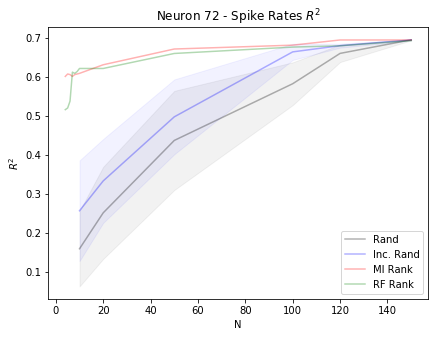

In [144]:
# TP = 147
#medidas = {(r,0,f,s,pp)
# (p,pp) -> (0,0), (1,1), (1,2)
def measurePlotter(TP,pconv,plotfile):
    #predicciones = cargarPredicciones(TP)
    #print(TP)
    medidas = cargarMedidas(TP)
    plt.figure(figsize=(15,5))
    p,pp = [(0,0),(1,1),(1,2)][pconv]
    med = ["Distance","$R^2$"]
    tip = ["Spikes","Spike Rates"]
    A = 6
    B = 15
    for t in [1]:
        for m in [1]:
            #plt.figure(figsize=(16,15))
            #plt.subplot(4,1,m*2+t+1)
            plt.subplot(1,2,m+1)
            plt.xlabel("N");plt.ylabel(med[m])
            rand = [np.array([medidas[(0,p,f,s,pp)][t][m]**2 for f in NsR[:A]]) for s in range(5)]
            irand = [np.array([medidas[(1,p,f,s,pp)][t][m]**2 for f in NsR[:A]]) for s in range(5)]
            stdrand = np.std(rand,axis=0)
            stdirand = np.std(irand,axis=0)
            plt.plot(NsR[:A],sum(rand)/5,"k-",alpha=0.3,label="Rand")
            plt.fill_between(NsR[:A], sum(rand)/5 - stdrand, sum(rand)/5 + stdrand, alpha=0.05,color="k")
            plt.plot(NsR[:A],sum(irand)/5,"b-",alpha=0.3,label="Inc. Rand")
            plt.fill_between(NsR[:A], sum(irand)/5 - stdirand, sum(irand)/5 + stdirand, alpha=0.05,color="b")
            #for s in range(4):
            #    plt.plot(NsR[:A],[medidas[(0,p,f,s,pp)][t][m] for f in NsR[:A]],"k.")
            #    plt.plot(NsR[:A],[medidas[(1,p,f,s,pp)][t][m] for f in NsR[:A]],"b-",alpha=0.3)
            plt.plot(Ns[:B],[medidas[(2,p,f,0,pp)][t][m]**2 for f in Ns[:B]],"r-",alpha=0.3,label="MI Rank")
            plt.plot(Ns[:B],[medidas[(3,p,f,0,pp)][t][m]**2 for f in Ns[:B]],"g-",alpha=0.3,label="RF Rank")
            #plt.plot(Ns[:B],[medidas[(4,p,f,0,pp)][t][m]**2 for f in Ns[:B]],"k-",alpha=0.3,label="Correl")
            plt.legend()
            plt.title("Neuron {0} - {2} {1}".format(TP,med[m],tip[t]))
    plt.savefig("plot{0}".format(dataset["fixed"])+plotfile+".pdf")
    savemat("R2N{}.mat".format(TP),{"rand":sum(rand)/5,"irand":sum(irand)/5,"stdrand":stdrand,
                         "stdirand":stdirand,
                         "MI":np.array([medidas[(2,p,f,0,pp)][t][m]**2 for f in Ns[:B]]),
                         "RF":[medidas[(3,p,f,0,pp)][t][m]**2 for f in Ns[:B]]})
#plt.plot(range(T-50)[:1000],np.array([np.sum(RASTER[dataset["fixed"]][i:i+50]) for i in range(0,T-50)])[:1000]/(1/TBASE))
#plt.plot(range(T-50)[:1000],predicciones[(0,0,50,4,0)][1][:1000])
#measurePlotter(0,"FullFull")
#measurePlotter(1,"PartialTrain")
#measurePlotter(2,"PartialTest")
for tp in [72]:#[2,10,20,31,49,72,119,120,127,147]:
    dataset = cargarDataset(tp)    
    #measurePlotter(tp,2,"PT")
    measurePlotter(tp,0,"FF")

Carga de archivo existente para neurona 2
[0.6068410000000001, 0.597529, 0.602176, 0.6146560000000001, 0.602176, 0.617796, 0.6084, 0.5929, 0.6037290000000001, 0.6561000000000001, 0.6674889999999999, 0.677329]
[0.5959840000000001, 0.585225, 0.5959840000000001, 0.6068410000000001, 0.594441, 0.6099610000000001, 0.6037290000000001, 0.586756, 0.591361, 0.6561000000000001, 0.6544810000000001, 0.6723999999999999]
[0.6304360000000001, 0.6146560000000001, 0.6225210000000001, 0.6336160000000001, 0.616225, 0.627264, 0.6193690000000001, 0.585225, 0.594441, 0.6609689999999999, 0.662596, 0.6822759999999999]
Carga de archivo existente para neurona 10
[0.33756099999999994, 0.34105599999999997, 0.33177599999999996, 0.36240399999999995, 0.352836, 0.357604, 0.36, 0.3721, 0.40195600000000004, 0.42902500000000005, 0.44355600000000006, 0.45562500000000006]
[0.3203559999999999, 0.3147210000000001, 0.32148899999999997, 0.355216, 0.34809999999999997, 0.351649, 0.34222499999999995, 0.37332099999999996, 0.398161

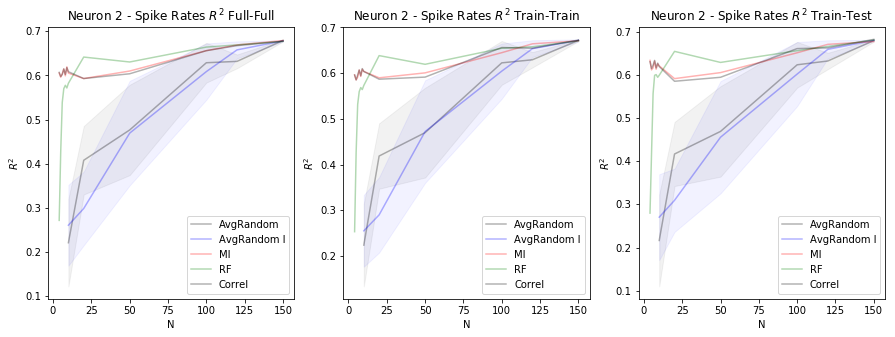

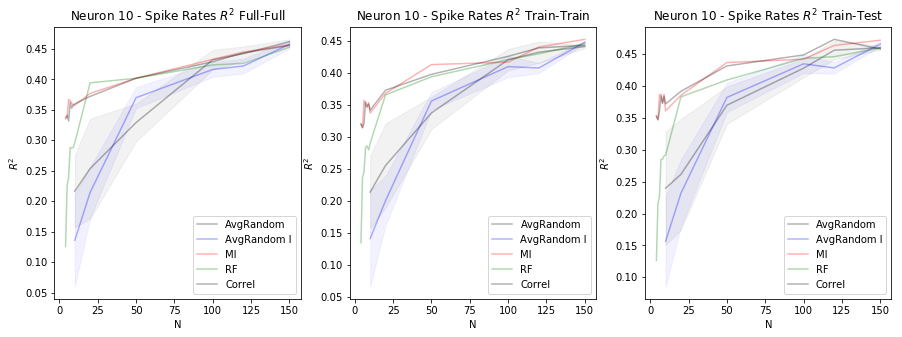

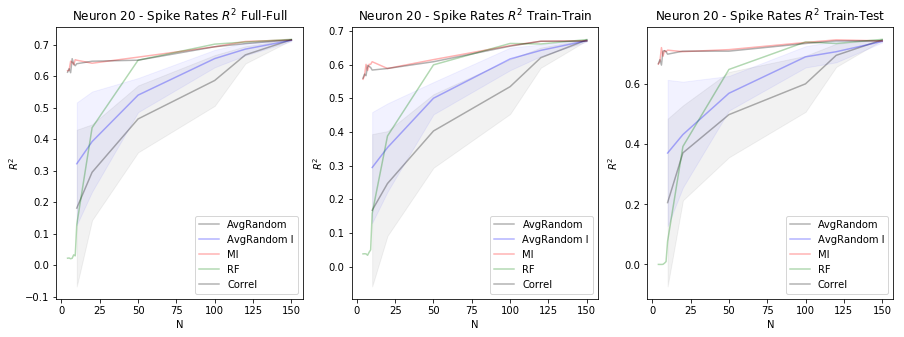

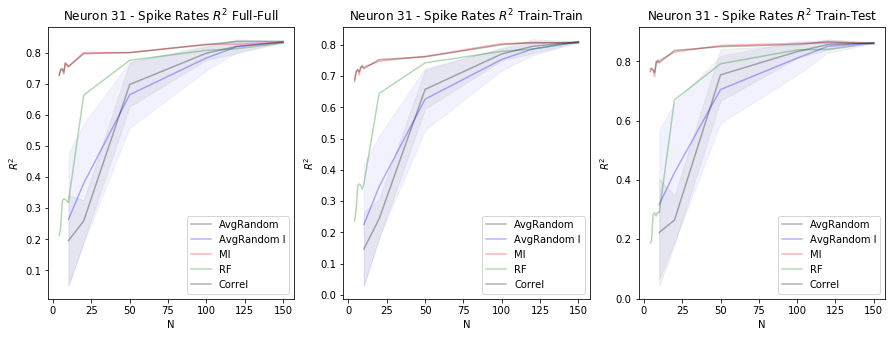

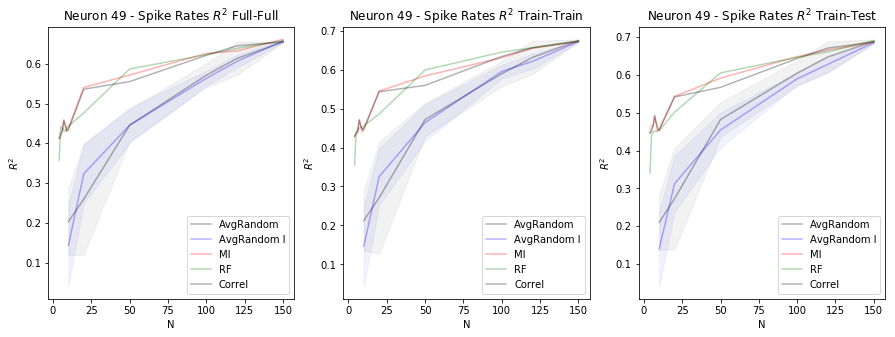

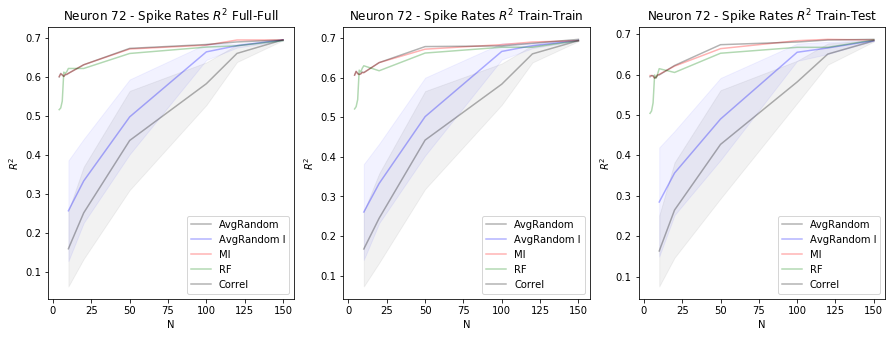

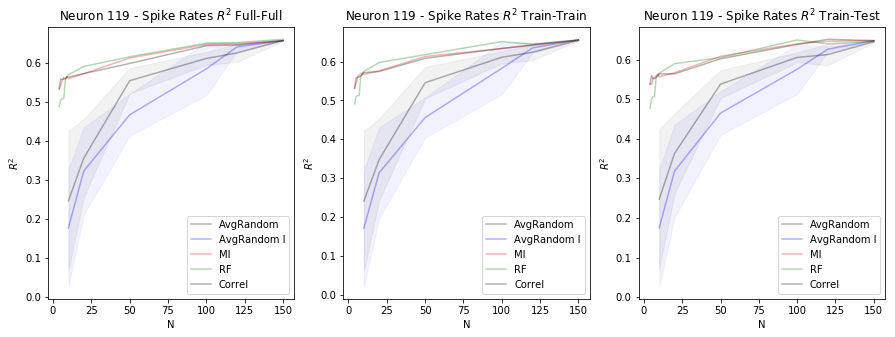

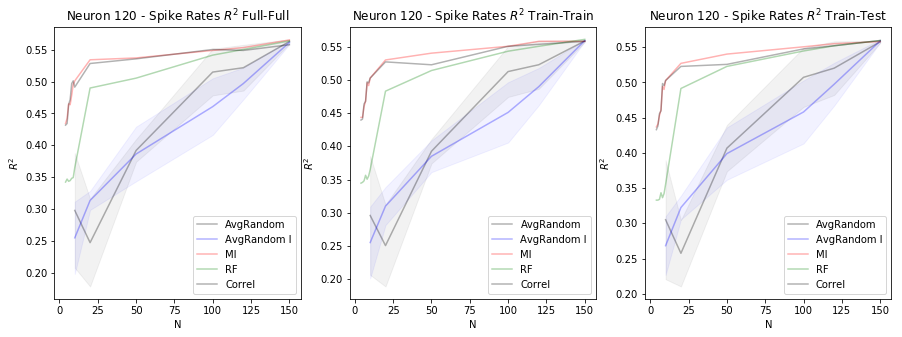

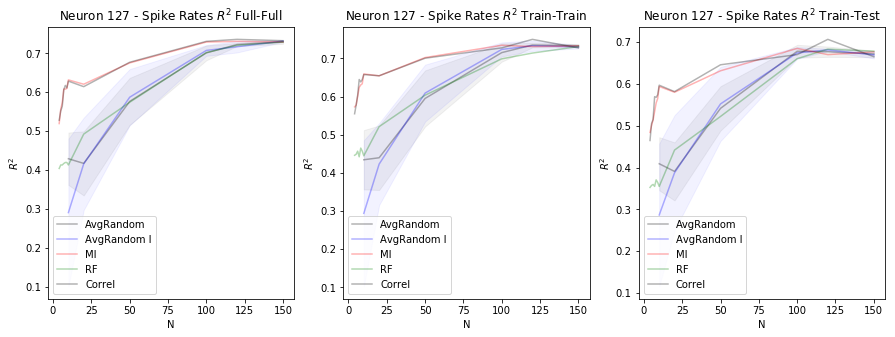

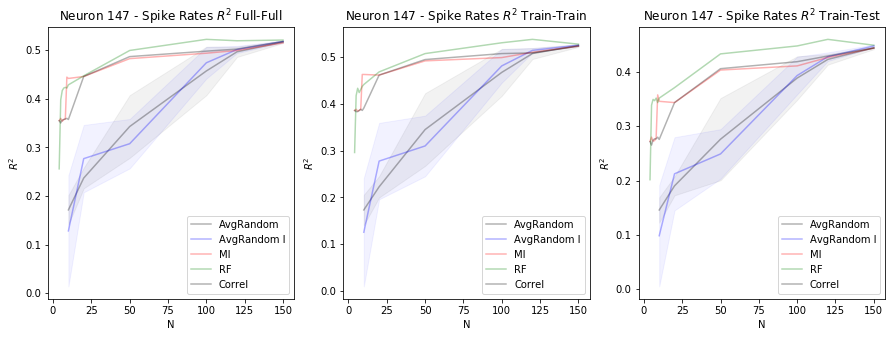

In [134]:
# TP = 147
#medidas = {(r,0,f,s,pp)
# (p,pp) -> (0,0), (1,1), (1,2)
def memoriaPlotter(TP,pconv,plotfile):
    #predicciones = cargarPredicciones(TP)
    #print(TP)
    medidas = cargarMedidas(TP)
    plt.figure(figsize=(15,5))
    #p,pp = [(0,0),(1,1),(1,2)][pconv]
    pselect = [(0,0),(1,1),(1,2)]
    med = ["Distance","$R^2$"]
    tip = ["Spikes","Spike Rates"]
    nom = ["Full-Full","Train-Train","Train-Test"]
    t,m= 1,1
    for pconv in [0,1,2]:
        p,pp = pselect[pconv]
        plt.subplot(1,3,pconv+1)
        plt.xlabel("N");plt.ylabel(med[m])
        rand = [np.array([medidas[(0,p,f,s,pp)][t][m]**2 for f in NsR]) for s in range(5)]
        irand = [np.array([medidas[(1,p,f,s,pp)][t][m]**2 for f in NsR]) for s in range(5)]
        stdrand = np.std(rand,axis=0)
        stdirand = np.std(irand,axis=0)
        plt.plot(NsR,sum(rand)/5,"k-",alpha=0.3,label="AvgRandom")
        plt.fill_between(NsR, sum(rand)/5 - stdrand, sum(rand)/5 + stdrand, alpha=0.05,color="k")
        plt.plot(NsR,sum(irand)/5,"b-",alpha=0.3,label="AvgRandom I")
        plt.fill_between(NsR, sum(irand)/5 - stdirand, sum(irand)/5 + stdirand, alpha=0.05,color="b")
        plt.plot(Ns,[medidas[(2,p,f,0,pp)][t][m]**2 for f in Ns],"r-",alpha=0.3,label="MI")
        plt.plot(Ns,[medidas[(3,p,f,0,pp)][t][m]**2 for f in Ns],"g-",alpha=0.3,label="RF")
        plt.plot(Ns,[medidas[(4,p,f,0,pp)][t][m]**2 for f in Ns],"k-",alpha=0.3,label="Correl")
        print([medidas[(4,p,f,0,pp)][t][m]**2 for f in Ns])
        plt.legend()
        plt.title("Neuron {0} - {2} {1} {3}".format(TP,med[m],tip[t],nom[pconv]))
        plt.savefig("plot{0}".format(dataset["fixed"])+plotfile+".svg")
#plt.plot(range(T-50)[:1000],np.array([np.sum(RASTER[dataset["fixed"]][i:i+50]) for i in range(0,T-50)])[:1000]/(1/TBASE))
#plt.plot(range(T-50)[:1000],predicciones[(0,0,50,4,0)][1][:1000])
#measurePlotter(0,"FullFull")
#measurePlotter(1,"PartialTrain")
#measurePlotter(2,"PartialTest")
#[2,31,49,72,119,120,127,147]
for tp in [2,10,20,31,49,72,119,120,127,147]:
    dataset = cargarDataset(tp)
    memoriaPlotter(tp,0,"FF")
    

In [ ]:
# PARAMS - PLOT
modname=matlines[80]
N=51
print(modname)
ising = loadmat("MatlabIsing/Models/{}.mat".format(modname))
params = ising["params"] # N , N*(N-1)/2
#print(params[:,0],len(params[:,0]),N)
P = np.zeros((N,N)) #FullMatrix for indexing
P[np.triu_indices(N, 1)] = params[:,0][N:] #UpperTri Matrix
H = np.diag(params[:,0][:N]) #<h,sigma>
sns.distplot(params[N:])

In [ ]:
# Measure Ranking per neuron -> Avg(Random), Avg(RandomInc), MI, C, RF 
# SpRate - R2 is absolute -> more is better
# default p,pp = 0,0
# default t,m = 1,1
def rankingMedidas(TP):
    p,pp =0,0
    medidas = cargarMedidas(TP)
    ranks = ["AvgRand","AvgIncRand","MI","RF","Corr"]
    norms = [np.linalg.norm(sum([np.array([medidas[(r,p,f,s,pp)][1][1] for f in NsR]) for s in range(ss)])/ss) for r,ss in [(0,5),(1,5),(2,1),(3,1),(4,1)]]
    norms = list(zip(ranks,norms))
    return list(zip(*sorted(norms,key=lambda x:x[1],reverse=True)))[0]

stats([10,2,20,31,49,72,119,120,127,147])
for n in [10,2,20,31,49,72,119,120,127,147]:
    print(n,rankingMedidas(n))

In [ ]:
def plotpredictedsprate(TP,r,f,s,window,steps,name="SpFigure"):
    data,SP = predicciones[(r,0,f,s,0)]
    #rank = {0:"Aleatorio",1:"Aleatorio Incremental",2:"por Información Mutua",4:"por Correlación",3:"por Campo Receptivo"}
    rank = {0:"Random",1:"Incremental Random",2:"Mutual Information Ranked",4:"Correlation Ranked",3:"Receptive Field Ranked"}
    sp = np.array([np.sum(RASTER[TP][i:i+window]) for i in range(0,T-window)])/(1/TBASE)
    #psp = np.array([np.sum(data[i:i+window]) for i in range(0,T-window)])/(1/TBASE)
    #totalact = np.sum(RASTER,axis=0)/RASTER.shape[0]
    #tsp = np.array([np.sum(totalact[i:i+window]) for i in range(0,T-window)])/(1/TBASE)
    ccoef = round(np.corrcoef(sp[:steps],SP[:steps])[0,1],2)
    ccoeft = round(np.corrcoef(sp[:],SP[:])[0,1],2)
    plt.figure(figsize=(25,5))
    #plt.title("Neurona {0} predicha en base a {1} neuronas del sample {2} {3} w_size={4} R2={5} // {6}".format(TP,f,s,rank[r],window,ccoef,ccoeft))
    plt.title("Neuron {0} predicted by {1} neurons from {3} sample {2} [w_size={4} R2={5} // tR2={6}]".format(TP,f,s,rank[r],window,ccoef,ccoeft))
    plt.plot(range(steps),gaussian_filter1d(sp[:steps],sigma=3),label="Original")
    #plt.plot(range(steps),gaussian_filter1d(psp[:steps],sigma=3),label="Predicted")
    plt.plot(range(steps),gaussian_filter1d(SP[:steps],sigma=3),label="Predicted")
    #plt.plot(range(steps),gaussian_filter1d(tsp[:steps],sigma=3),"--",label="RasterAverage",alpha=0.3)
    plt.ylabel("Spike Rate")
    plt.xlabel("Time Bin")
    plt.legend()
    plt.show()
    #m = max(max(sp[:steps]),max(psp[:steps]))
    #dists = np.array([np.sqrt(abs(sp[n]-psp[n])/np.sqrt(2)) for n in range(steps)])
    #dists/=max(dists)
    #plt.scatter(a,b,c=[[1-d,d,1] for d in dists],marker=".")
    #plt.scatter(sp[:steps],psp[:steps],marker=".",alpha=0.1)
    #plt.show()
    #plt.savefig(name+".png")
    
    #plt.figure(figsize=(10,10))
    #plt.scatter(sp[:steps],psp[:steps],alpha=0.03)


obj = 30
predicciones = cargarPredicciones(obj)
plotpredictedsprate(obj,0,50,0,50,3000)
plotpredictedsprate(obj,0,120,0,50,3000)
plotpredictedsprate(obj,2,10,0,50,3000)
plotpredictedsprate(obj,2,100,0,50,3000)


In [169]:
from ipywidgets import interact_manual
#SpRate plot para mPredictions
def Plot(TP,r,f,s,r2,f2,s2):
    F = open('mPredictions/N{0}.pkl'.format(TP), 'rb')   # 'rb' for reading binary file
    mpredicciones = pickle.load(F)    
    F.close()
    SP = mpredicciones[(r,0,f,s,0)]
    SP2 = mpredicciones[(r2,0,f2,s2,0)]
    #rank = {0:"Random",1:"Incremental Random",2:"Mutual Information Ranked",4:"Correlation Ranked",3:"Receptive Field Ranked"}
    rank = {0:"Random",1:"Inc. Random",2:"MI Rank",4:"Corr. Rank",3:"RFD Rank"}
    sp = np.array([np.sum(RASTER[TP][i:i+50]) for i in range(0,T-50)])/(1/TBASE)
    plt.figure(figsize=(10,5))
    plt.title("Neuron {0} Firing Rate".format(TP))
    plt.plot(range(3000),gaussian_filter1d(sp[:3000],sigma=3),
             label="Original",linewidth=2)
    #plt.plot(range(3000),gaussian_filter1d(SP,sigma=3),
    #         label="Predicted".format(f,rank[r]),alpha=0.6,linewidth=2)
    plt.plot(range(3000),gaussian_filter1d(SP,sigma=3),
             label="N{0} {1}".format(f,rank[r]),alpha=0.6,linewidth=2)
    plt.plot(range(3000),gaussian_filter1d(SP2,sigma=3),
             label="N{0} {1}".format(f2,rank[r2]),alpha=0.6,linewidth=2)
    plt.xlim(500,1500)
    plt.ylabel("Firing Rate",fontsize=14)
    plt.xlabel("Time Bin",fontsize=14)
    plt.legend(fontsize=12)
    #plt.xticks([]);plt.yticks([])
    print(len(SP))
    savemat("SpRate{}.mat".format(TP),{"Original":gaussian_filter1d(sp[:3000],sigma=3) ,"MI{}".format(f):gaussian_filter1d(SP,sigma=3),"Rand{}".format(f2):gaussian_filter1d(SP2,sigma=3)})
    plt.show()
    
interact_manual(Plot,TP=(0,151,1),
               r=(0,4,1),f=[10,20,50,100,120,150],s=0,
               r2=(0,4,1),f2=[10,20,50,100,120,150],s2=0)
#interact_manual(Plot,TP=(0,84,1),
#               r=(0,4,1),f=[10,20,50,100,120,150],s=0)
#N= 21,29
#144 2-10  0-20

interactive(children=(IntSlider(value=75, description='TP', max=151), IntSlider(value=2, description='r', max=…

<function __main__.Plot(TP, r, f, s, r2, f2, s2)>

In [86]:
# Overall f=[5,10,20] R^2
nlist = list(range(90,110))
listaMedidas = [cargarMedidas(n) for n in nlist]
for r in [0,1,2,3,4]:
    print("Criterio",r,*["%6s"%nn for nn in nlist])
    for f in [10,20,50,100,120,150]: #sample 0 full-full
        print("Fijas:","%3s"%f,end=" ")
        for n in range(len(nlist)):
            print("%6s" % round(listaMedidas[n][(r,0,f,0,0)][1][1]**2,3),end=" ")
        print()

Criterio 0     90     91     92     93     94     95     96     97     98     99    100    101    102    103    104    105    106    107    108    109
Fijas:  10  0.079  0.001  0.158  0.262  0.154  0.108  0.171  0.172  0.176  0.001  0.186  0.346  0.032  0.092  0.205  0.168  0.134  0.064  0.018  0.019 
Fijas:  20  0.095  0.112  0.114  0.212  0.242  0.387  0.144  0.247  0.244  0.191  0.065  0.319  0.174  0.109  0.204  0.224  0.256  0.396  0.399  0.192 
Fijas:  50  0.491  0.184  0.243  0.402  0.472  0.637  0.144  0.378  0.298  0.262  0.352  0.543  0.141    0.2  0.384  0.176  0.213  0.373  0.523  0.275 
Fijas: 100  0.567  0.225  0.497  0.442  0.572  0.717  0.296  0.476  0.393  0.388   0.48  0.602  0.226  0.211  0.402  0.424  0.278  0.477   0.59  0.324 
Fijas: 120  0.529  0.295  0.491   0.51  0.567  0.722  0.293  0.491  0.423  0.437  0.531  0.605  0.228  0.266  0.434  0.425  0.305  0.432  0.591  0.361 
Fijas: 150  0.561  0.336  0.521  0.552  0.624  0.734  0.294  0.587  0.449  0.472  0.551  

In [100]:
todasMedidas = [cargarMedidas(n) for n in range(151)]

In [59]:
fijas = [(10,50),(10,10),(50,50)]
ranks = [(2,0),(0,3),(0,2)]

def maxdif(f1,f2,r1,r2):
    maxval=0
    nn = 0
    for n in range(115):
        submed = todasMedidas[n]
        delta = abs(submed[(r1,0,f1,0,0)][1][0]-submed[(r2,0,f2,0,0)][1][0])
        if delta>maxval:
            maxval=delta
            nn=n
    return nn
for n in range(3):
    print(fijas[n],ranks[n],maxdif(*fijas[n],*ranks[n]))


(10, 50) (2, 0) 21
(10, 10) (0, 3) 21
(50, 50) (0, 2) 21


In [168]:
def plotMedida(r,f,r2,f2,sort):
    rank = {0:"Random",1:"Incremental Random",2:"Mutual Information Ranked",4:"Correlation Ranked",3:"Receptive Field Ranked"}
    redrank = {0:"Rand",1:"Inc. Rand",2:"MI Rank",4:"Corr Rank",3:"RF Rank"}
    plt.figure(figsize=(15,5))
    yData=[todasMedidas[n][(r,0,f,0,0)][1][1]**2 for n in range(151)]
    yData2=[todasMedidas[n][(r2,0,f2,0,0)][1][1]**2 for n in range(151)]
    if sort:
        yData=sorted(yData)[::-1]
        yData2=sorted(yData2)[::-1]
    plt.title(rank[r]+" Fijas: {0}   ".format(f)+rank[r2]+" Fijas: {0}".format(f2))
    plt.scatter(range(151),yData,label=redrank[r]+"({0})".format(f))
    plt.plot(range(151),yData,alpha=0.5)
    plt.scatter(range(151),yData2,label=redrank[r2]+"({0})".format(f2))
    plt.plot(range(151),yData2,alpha=0.5)
    plt.ylabel("$R^2$")
    plt.xlabel("Neuronas")
    plt.grid()
    plt.legend()
    plt.show()
    #ax = sns.violinplot(data=[yData,yData2])
    #ax.legend(["A","B"])
    plt.figure(figsize=(10,5))
    plt.title("$R^2$ Distributions")
    vp = plt.violinplot([yData,yData2])
    savemat("ViolinR20MI20.mat",{"R20":yData,"MI10":yData2})
    vp["bodies"][0].set_color("blue")
    plt.legend([redrank[r]+"({0})".format(f),redrank[r2]+"({0})".format(f2)],loc="upper center")
    for y1,y2 in zip(yData,yData2):
        plt.plot([1,2],[y1,y2],alpha=0.2,c="#B2B2FF") #["red","green"][int(y2>y1)]
    #plt.title(rank[r2]+" Fijas: {0}".format(f2))
    plt.xticks([])
    plt.savefig("ViolinRand20MI20.pdf")
    plt.show()
    
def ScatterMatrix(f,f2,i):
    redrank = {0:"Rand",1:"Inc. Rand",2:"MI Rank",4:"Corr Rank",3:"RF Rank"}
    #i = 1
    #f,f2 = 10,10
    #plt.figure(figsize=(8,3))
    for r2 in [0]:
        for r in [2,3]:
            if r==r2:
                continue
            plt.subplot(3,2,i)
            yData=[todasMedidas[n][(r,0,f,0,0)][1][1]**2 for n in range(151)]
            yData2=[todasMedidas[n][(r2,0,f2,0,0)][1][1]**2 for n in range(151)]
            plt.scatter(yData,yData2,marker=".")
            maxvalue=max(max(yData),max(yData2))
            plt.xlim(0,maxvalue)
            plt.ylim(0,maxvalue)
            plt.plot([(0,0),(1,1)],alpha=0.3)
            #if i in [1,2]:
            plt.xlabel(redrank[r]+"({0})".format(f))
            #if i in [1,5,9,13]:
            plt.ylabel(redrank[r2]+"({0})".format(f2))
            i+=1
    #plt.tight_layout()
    #plt.show()
    return np.array([yData,yData2])
interact_manual(plotMedida,r=(0,4,1),f=[10,20,50,100,120,150],r2=(0,4,1),f2=[10,20,50,100,120,150],sort=False)


"""
tomat= {}
plt.figure(figsize=(8,9))
#plt.subplot(1,2,i)
tomat["Rand10MI10"]=ScatterMatrix(10,10,1)
tomat["Rand50MI20"]=ScatterMatrix(20,50,3)
tomat["Rand100MI100"]=ScatterMatrix(100,100,5)
plt.tight_layout()
plt.savefig("Fig6.pdf")
plt.show()
savemat("Fig6.mat",tomat)
"""
# Poder comparar perfiles de ranking (idem comparación de predicciones arriba) , agregar leyenda
#---
# Fijar R2 y ver # de neuronas*/
# Poner título
# Poner leyenda
# ViolinPlots / Barra para distribución de R^2 para cada uno de los criterios X(criterios) Y(R^2) 

interactive(children=(IntSlider(value=2, description='r', max=4), Dropdown(description='f', options=(10, 20, 5…

'\ntomat= {}\nplt.figure(figsize=(8,9))\n#plt.subplot(1,2,i)\ntomat["Rand10MI10"]=ScatterMatrix(10,10,1)\ntomat["Rand50MI20"]=ScatterMatrix(20,50,3)\ntomat["Rand100MI100"]=ScatterMatrix(100,100,5)\nplt.tight_layout()\nplt.savefig("Fig6.pdf")\nplt.show()\nsavemat("Fig6.mat",tomat)\n'

      Rand       -       -       -       -       -       -   0.176   0.259   0.382   0.469   0.486   0.516 
 Inc. Rand       -       -       -       -       -       -   0.182   0.262   0.372    0.46   0.483   0.516 
   MI Rank   0.381   0.395   0.402   0.411   0.417   0.421   0.425   0.447   0.472   0.499   0.506   0.516 
   RF Rank   0.274   0.301   0.327   0.341   0.353   0.363    0.37   0.418   0.463   0.497   0.505   0.516 


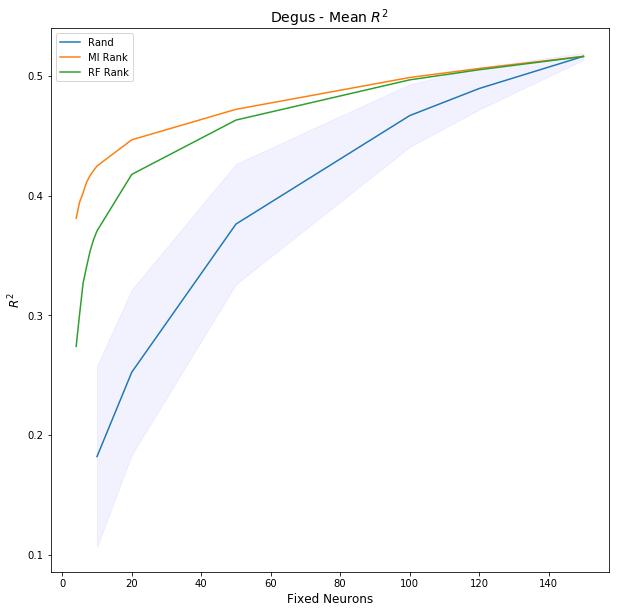

In [105]:
# All Mean R2 table & Plot
redrank = {0:"Rand",1:"Inc. Rand",2:"MI Rank",4:"Corr Rank",3:"RF Rank"}
r2data = [[],[],[],[]]
gray = [[],[],[],[]]
for r in range(4):
    #r2data[r]=[]
    #gray[r]=[]
    print("%10s"%redrank[r],end=" ")
    for f in [4,5,6,7,8,9,10,20,50,100,120,150]:
        if r in [0,1]:
            if f in [4,5,6,7,8,9]:
                print("%7s"%"-",end=" ")
                r2data[r].append(np.nan)
                gray[r].append(np.nan)
                continue
            r2data[r].append(np.mean([np.mean([todasMedidas[n][(r,0,f,s,0)][1][1]**2 for s in range(5)]) for n in range(151)]))
            gray[r].append(np.mean([np.std([todasMedidas[n][(r,0,f,s,0)][1][1]**2 for s in range(5)]) for n in range(151)]))
        else:
            r2data[r].append(np.mean([todasMedidas[n][(r,0,f,0,0)][1][1]**2 for n in range(151)]))
            gray[r].append(np.std([todasMedidas[n][(r,0,f,0,0)][1][1]**2 for n in range(151)]))
        print("%7s"%np.round(np.mean([todasMedidas[n][(r,0,f,0,0)][1][1]**2 for n in range(151)]),3),end=" ")
    print()
    r2data[r]=np.array(r2data[r])
    gray[r]=np.array(gray[r])

plt.figure(figsize=(10,10))
for r in [0,2,3]:#range(4):
    plt.plot([4,5,6,7,8,9,10,20,50,100,120,150],r2data[r],label=redrank[r])
    if r in [0,1]:
        plt.fill_between([4,5,6,7,8,9,10,20,50,100,120,150], r2data[r] - gray[r], r2data[r] + gray[r], alpha=0.05,color="b")
plt.title("Degus - Mean $R^2$",fontsize=14)
plt.xlabel("Fixed Neurons",fontsize=12)
plt.ylabel("$R^2$",fontsize=12)
plt.legend()
#plt.show()
plt.savefig("MeanR2.pdf")
plt.show()
savemat("Meanr2.mat",{"r2data":np.array(r2data),"std":np.array(gray),"x":np.array([4,5,6,7,8,9,10,20,50,100,120,150])})

## SpRate v/s Avg(R2)

R2 Predictability and SpRate
MI: 0.416674555038349
RF: 0.24091915830632796
CO: 0.4158927101413793


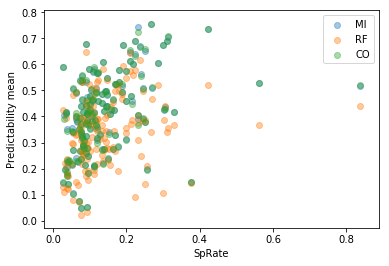

In [150]:
# All Mean R2 table & Plot
redrank = {0:"Rand",1:"Inc. Rand",2:"MI Rank",4:"Corr Rank",3:"RF Rank"}
SPrate = np.sum(RASTER,axis=1)/RASTER.shape[1]
indr2data = {}
for r in range(5):
    indr2data[r]={}
    for n in range(151):
        indr2data[r][n]=[]
        for f in [4,5,6,7,8,9,10,20]:
            if r in [0,1]:
                if f in [4,5,6,7,8,9]:
                    indr2data[r][n].append(np.nan)
                    continue
            indr2data[r][n].append(todasMedidas[n][(r,0,f,0,0)][1][1]**2)
        indr2data[r][n]=np.mean(indr2data[r][n])
    indr2data[r][n]=np.mean(indr2data[r][n])

#print(len(indr2data[3]),len(SPrate))
#plt.scatter(indr2data,SPrate)
plt.xlabel("SpRate")
plt.ylabel("Predictability mean")
plt.scatter(SPrate,[indr2data[2][n] for n in range(151)],alpha=0.4,label="MI")
plt.scatter(SPrate,[indr2data[3][n] for n in range(151)],alpha=0.4,label="RF")
plt.scatter(SPrate,[indr2data[4][n] for n in range(151)],alpha=0.4,label="CO")
plt.legend()
print("R2 Predictability and SpRate")
print("MI:",np.corrcoef(SPrate,[indr2data[2][n] for n in range(151)])[0,1])
print("RF:",np.corrcoef(SPrate,[indr2data[3][n] for n in range(151)])[0,1])
print("CO:",np.corrcoef(SPrate,[indr2data[4][n] for n in range(151)])[0,1])

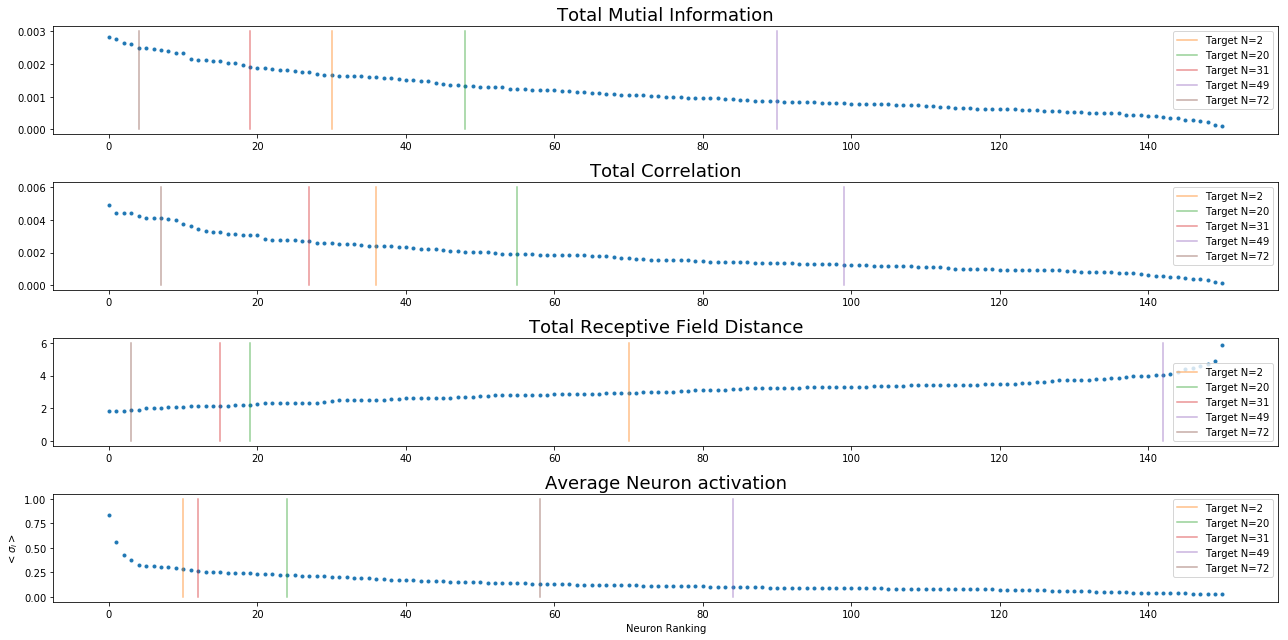

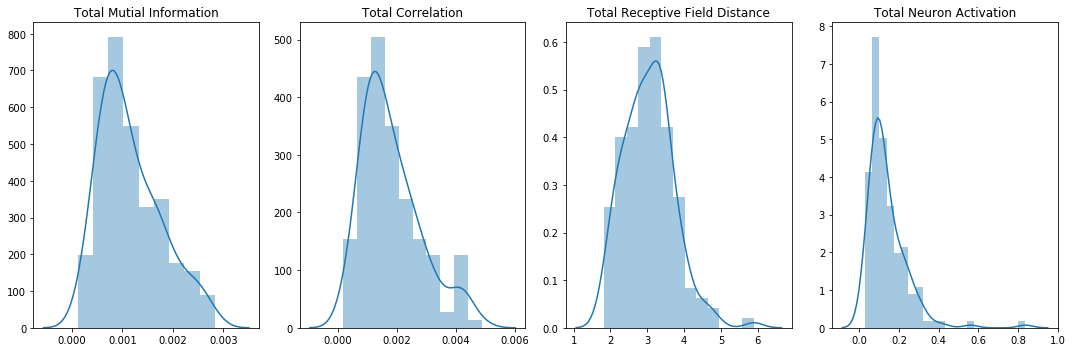

In [171]:
### 6 - Generación de visualizaciones
#### Función de visualización de raster/spRate v/s su predicción correspondiente
def spRateVis(r,f,s,window,size): #ranking fixed sample
    predicted = predicciones[(r,0,f,s,0)][1] #datos
    #preSpRate = np.array([np.sum(predicted[i:i+50]) for i in range(0,T-50)])/(1/TBASE)
    spRate = np.array([np.sum(RASTER[TP][i:i+50]) for i in range(0,T-50)])/(1/TBASE)
    plt.figure(figsize=(25,5))
    plt.plot(range(3000),predicted[:3000])
    plt.plot(range(3000),spRate[:3000])
    plt.title("cosa")
    plt.xlabel("t")
    plt.ylabel("SpikeRate")
    return 0
#### Función para visualizar las métricas de rendimiento de las predicciones

#### Función para visualizar los espacios de métricas utilizadas

#### Función para visualizar la caracterización de una neurona (Activación,EspacioMI,EspacioR,EspacioRF)
"""
def caracterizacion2D(neuron = dataset["fixed"]):
    plt.figure(figsize=(18,9))
    plt.subplot(2,3,1)
    plt.title("Receptive Field Space",fontsize=18)
    plt.scatter(Dpoints[:,0],Dpoints[:,1],marker=".")
    plt.scatter(Dpoints[neuron,0],Dpoints[neuron,1],label="Target N={0}".format(neuron))
    plt.legend()
    plt.subplot(2,3,2)
    plt.title("Mutual Information Space",fontsize=18)
    plt.xlim(-0.005,0.005)
    plt.scatter(MIpoints[:,0],Dpoints[:,1],marker=".")
    plt.scatter(MIpoints[neuron,0],MIpoints[neuron,1],label="Target N={0}".format(neuron))
    plt.legend()
    plt.subplot(2,3,3)
    plt.title("Correlation Space",fontsize=18)
    plt.xlim(-0.005,0.005)
    plt.scatter(CCpoints[:,0],Dpoints[:,1],marker=".")
    plt.scatter(CCpoints[neuron,0],CCpoints[neuron,1],color="r",label="Target N={0}".format(neuron))
    plt.legend()
    plt.subplot(2,1,2)
    plt.title("Average Neuron activation",fontsize=18)
    plt.ylabel("$<\sigma_i>$")
    plt.xlabel("Neuron Ranking")
    sprank = sorted(np.sum(RASTER,axis=1)/RASTER.shape[1],reverse=1)
    plt.plot(range(RASTER.shape[0]),sprank,".")
    plt.plot([sprank.index(np.sum(RASTER,axis=1)[neuron]/RASTER.shape[1])]*2,[0.0,1.0],"r",alpha=0.5,label="Target N={0}".format(neuron))
    plt.legend()
    plt.tight_layout()
"""
    
def caracterizacion1D(neurons):
    fig = plt.figure(figsize=(18,9))
    plt.subplot(4,1,1)
    plt.title("Total Mutial Information",fontsize=18)
    mirank = sorted(np.sum(MI,axis=1)/MI.shape[1],reverse=1)
    plt.plot(range(MI.shape[0]),mirank,".")
    for neuron in neurons:
        plt.plot([mirank.index(np.sum(MI,axis=1)[neuron]/MI.shape[1])]*2,[0.0,0.003],alpha=0.5,label="Target N={0}".format(neuron))
    plt.legend()
    plt.subplot(4,1,2)
    plt.title("Total Correlation",fontsize=18)
    ccrank = sorted(np.sum(CC,axis=1)/CC.shape[1],reverse=1)
    plt.plot(range(CC.shape[0]),ccrank,".")
    for neuron in neurons:
        plt.plot([ccrank.index(np.sum(CC,axis=1)[neuron]/CC.shape[1])]*2,[0.0,0.006],alpha=0.5,label="Target N={0}".format(neuron))
    plt.legend()
    plt.subplot(4,1,3)
    plt.title("Total Receptive Field Distance",fontsize=18)
    rfrank = sorted(np.sum(D,axis=1)/D.shape[1])
    plt.plot(range(D.shape[0]),rfrank,".")
    for neuron in neurons:
        plt.plot([rfrank.index(np.sum(D,axis=1)[neuron]/D.shape[1])]*2,[0.0,6],alpha=0.5,label="Target N={0}".format(neuron))
    plt.legend()
    plt.subplot(4,1,4)
    plt.title("Average Neuron activation",fontsize=18)
    plt.ylabel("$<\sigma_i>$")
    plt.xlabel("Neuron Ranking")
    sprank = sorted(np.sum(RASTER,axis=1)/RASTER.shape[1],reverse=1)
    plt.plot(range(RASTER.shape[0]),sprank,".")
    #plt.ylim(0.0,0.2)
    for neuron in neurons:
        plt.plot([sprank.index(np.sum(RASTER,axis=1)[neuron]/RASTER.shape[1])]*2,[0.0,1.0],alpha=0.5,label="Target N={0}".format(neuron))
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,4,1)
    plt.title("Total Mutial Information")
    sns.distplot(mirank)
    plt.subplot(1,4,2)
    plt.title("Total Correlation")
    sns.distplot(ccrank)
    plt.subplot(1,4,3)
    plt.title("Total Receptive Field Distance")
    sns.distplot(rfrank)
    plt.subplot(1,4,4)
    plt.title("Total Neuron Activation")
    sns.distplot(sprank)
    plt.tight_layout()
    #return fig
    
def stats(neuron): #Avg SpRate, Sum(MI),Sum(D),Sum(C) & Ranks
    Dindex,Dsums = list(zip(*sorted(enumerate(np.sum(D,axis=1)),key=lambda x:x[1])))
    Cindex,Csums = list(zip(*sorted(enumerate(np.sum(CC,axis=1)),reverse=True,key=lambda x:x[1])))
    MIindex,MIsums = list(zip(*sorted(enumerate(np.sum(MI,axis=1)),reverse=True,key=lambda x:x[1])))
    SPindex,SPsums = list(zip(*sorted(enumerate(np.sum(RASTER,axis=1)),reverse=True,key=lambda x:x[1])))
    #for neuron in neurons:
    #    print("RF:{} - Cor:{} - MI:{} - SP:{}".format(MIindex.index(neuron),Cindex.index(neuron),Dindex.index(neuron),SPindex.index(neuron)))
    return [MIindex.index(neuron),Cindex.index(neuron),Dindex.index(neuron),SPindex.index(neuron)]
    #print("RF Distance:\n{0}\t#{1}\nSumMI:\n{2}\t#{3}\nSumCC\n{4}\t{5}".format(ds,Dsums.index(ds),ms,MIsums.index(ms),cs,Csums.index(cs)))


        

#interact(caracterizacion,neuron=IntSlider(min=0,max=N, step=1,value=dataset["fixed"]))

neuronset = [2,20,31,49,72]
caracterizacion1D(neuronset)
#stats(neuronset)

In [182]:
for T in []:
    ds = cargarDataset(T)
    enu = sorted(enumerate(MI[T]),key = lambda x:x[1],reverse=1)
    unzipe = list(list(zip(*list(enu)))[0])
    unzipe.remove(T)
    dedat = ds["2"]["150"][0]
    print(unzipe)
    print(dedat)
    plt.scatter(unzipe,dedat,marker=".")
ising = loadmat("MatlabIsing/Models/E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,147,2,1,9,0))
N=10
params = ising["params"] # N , N*(N-1)/2
#print(params[:,0],len(params[:,0]),N)
P = np.zeros((N,N)) #FullMatrix for indexing
P[np.triu_indices(N, 1)] = params[:,0][N:] #UpperTri Matrix
P = P+np.diag(params[:,0][:N]) #<h,sigma>

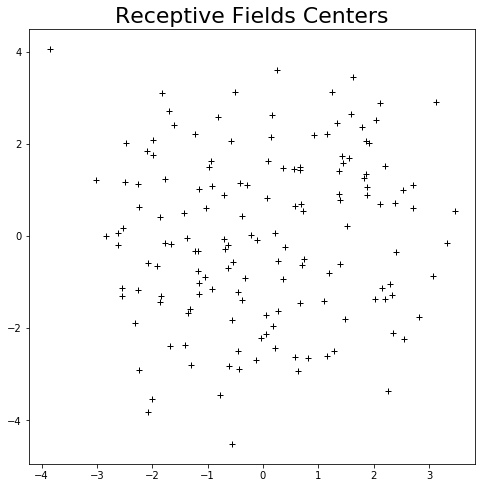

In [111]:
plt.figure(figsize=(8,8))
plt.title("Receptive Fields Centers",fontsize="22")
plt.scatter(Dpoints[:,0],Dpoints[:,1],marker="+",color="k",linewidth=1)

# No considerar de acá hacia abajo

In [2]:
def autocorrelate(V,lags=None):
    V = V/np.linalg.norm(V)
    if lags == None:
        return np.correlate(V,V,"full")
    return np.correlate(V,V,"full")[int(len(V)-lags)-1:int(len(V)+lags)]
def spr(V,I):
    return np.array([np.sum(V[i:i+I]) for i in range(0,len(V)-I)])/(1/TBASE)
#SpikeRates
sprates = [spr(RASTER[i],50) for i in range(N)]

LAGS = 1600
#plt.figure(figsize=(25,3))
#plt.plot(np.arange(-LAGS,LAGS+1,1),np.sum([autocorrelate(sprates[i],LAGS) for i in range(N)],axis=0)/N)

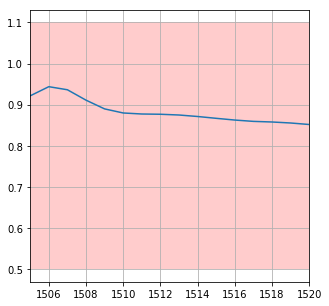

In [23]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(-2000,2001),autocorrelate(np.sum(RASTER,axis=0),2000))
plt.fill([-50,-50,50,50],[0.5,1.1,1.1,0.5],"r",alpha=0.2)
plt.fill([-1556,-1556,-1456,-1456],[0.5,1.1,1.1,0.5],"r",alpha=0.2)
plt.fill([1556,1556,1456,1456],[0.5,1.1,1.1,0.5],"r",alpha=0.2)
plt.xlim(1505,1520)
plt.grid()

In [14]:
.shape

(61809,)

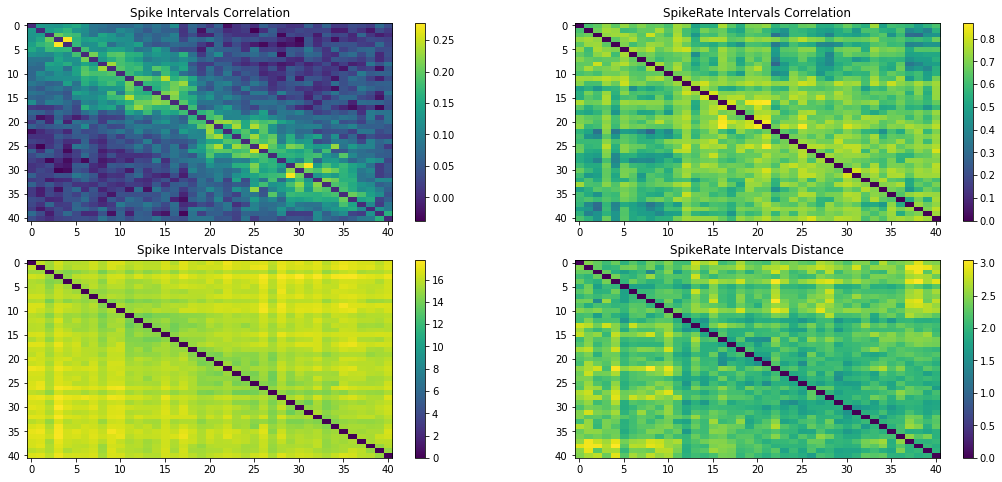

In [106]:
spli = np.split(RASTER[120][:-63],41)
splispr = np.split(spr(RASTER[120],50)[:-13],41)
plt.figure(figsize=(18,8))
plt.subplot(2,2,1)
plt.title("Spike Intervals Correlation")
MAT = np.array([[ np.corrcoef(j,i)[0][1] for j in spli] for i in spli])-np.diag(np.ones(41))
plt.imshow(MAT,aspect="auto")
plt.colorbar()
plt.subplot(2,2,2)
plt.title("SpikeRate Intervals Correlation")
MAT = np.array([[ np.corrcoef(j,i)[0][1] for j in splispr] for i in splispr])-np.diag(np.ones(41))
plt.imshow(MAT,aspect="auto")
plt.colorbar()
plt.subplot(2,2,3)
plt.title("Spike Intervals Distance")
MAT = np.array([[ np.linalg.norm(j-i) for j in spli] for i in spli])
plt.imshow(MAT,aspect="auto")
plt.colorbar()
plt.subplot(2,2,4)
plt.title("SpikeRate Intervals Distance")
MAT = np.array([[ np.linalg.norm(j-i) for j in splispr] for i in splispr])
plt.imshow(MAT,aspect="auto")
plt.colorbar()


In [115]:
reRaster = np.sum(np.split(RASTER[:,:-63],41,axis=1),axis=0)

In [122]:
np.sum(cubed[0]-np.split(RASTER[:,:-63],41,axis=1)[0])

0.0

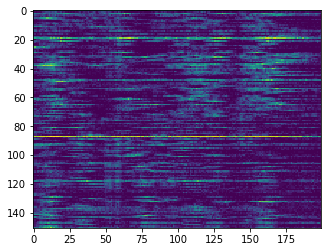

In [117]:
plt.imshow(reRaster[:,:200])

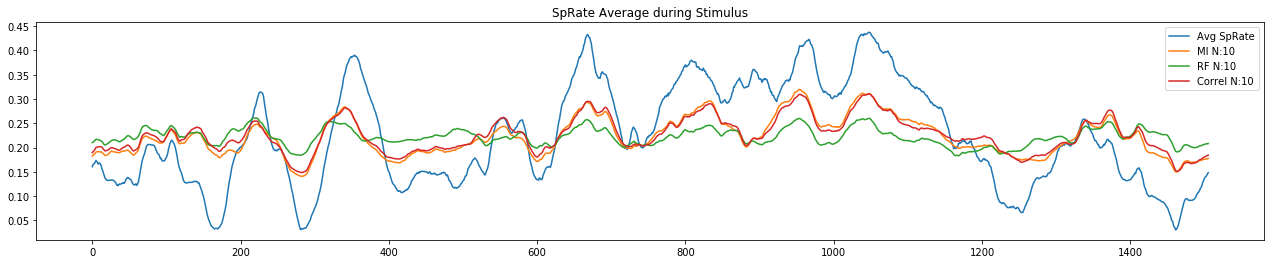

In [1095]:
splispr = np.split(spr(RASTER[TP],50)[:-13],41)
plt.figure(figsize=(22,4))
plt.title("SpRate Average during Stimulus")
#for n in range(41):
        #plt.plot(range(len(splispr[0])),splispr[n],"b",alpha=0.02)
plt.plot(range(len(splispr[0])),sum(splispr)/41,label="Avg SpRate")
for n in [10]:
    presplispr = sum(np.split(predicciones[(2,0,n,0,0)][1][:-13],41))/41
    plt.plot(range(len(splispr[0])),presplispr,label="MI N:{0}".format(n))
    presplispr = sum(np.split(predicciones[(3,0,n,0,0)][1][:-13],41))/41
    plt.plot(range(len(splispr[0])),presplispr,label="RF N:{0}".format(n))
    presplispr = sum(np.split(predicciones[(4,0,n,0,0)][1][:-13],41))/41
    plt.plot(range(len(splispr[0])),presplispr,label="Correl N:{0}".format(n))
plt.legend()
plt.savefig("predict.svg")

In [738]:
def modelCheck(num,verbose=0,lacking = 0):
    allmods = os.listdir("MatlabIsing/Models")
    current = 0
    tot = 0
    for rank in [0,1,2,3,4]: #tipo de ranking
        if rank in [0,1]:
            flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
        else:
            flist,slist = [1,2,3,4,5,6,7,8,9,10,20,50,100,120,150],[0]
        for f in flist: #neuronas fijadas
            for s in slist: #samples
                for p in [0,1]:
                    tot+=1
                    nom = "E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,num,rank,p,f,s)
                    current+=nom in allmods
                    if verbose:
                        print (nom,nom in allmods)
                    if lacking and nom not in allmods:
                        print ("Ajustar('Rankings','Models','{0}');".format(nom))
    print ("Current Models: {0}/{1}".format(current,tot))
                
modelCheck(147,0,1)

Current Models: 210/210


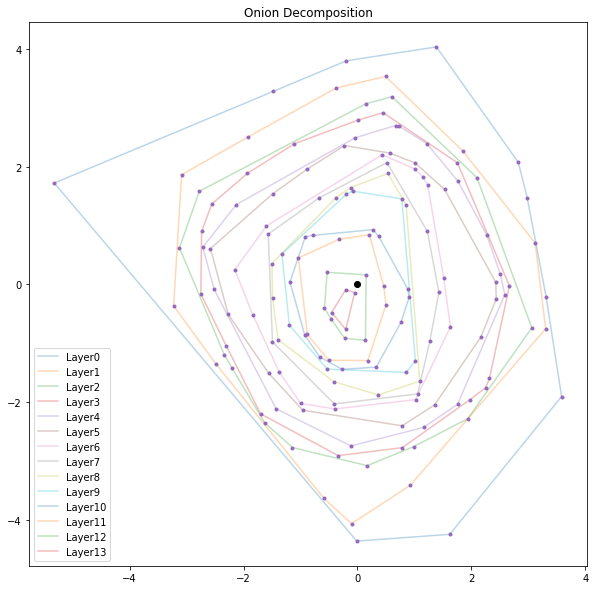

In [763]:

def onionDecomposition(points,plot=1):
    layerPoints = {} #layer plot tuples
    layerIndexes = {}
    cpoints = points #copy
    lindex = 0
    while len(points)>2:
        hull = ConvexHull(points)
        hv = hull.vertices[np.arange(0,len(hull.vertices)+1,1)%len(hull.vertices)]
        layerPoints[lindex] = (points[hv,0],points[hv,1])
        layerIndexes[lindex] = hv[:-1]
        points = points[list(set(range(len(points)))-set(hv))]
        lindex+=1
    if plot:
        plt.figure(figsize=(10,10))
        plt.title("Onion Decomposition")
        for l,coord in layerPoints.items():
            plt.plot(coord[0],coord[1],alpha=0.3,label="Layer{0}".format(l))
        plt.plot(cpoints[:,0],cpoints[:,1],".")
        plt.plot(np.average(cpoints[:,0]),np.average(cpoints[:,1]),"ok")
        plt.legend()
    return layerPoints,layerIndexes
    

puntos = np.random.rand(100, 2)
layerpoints,layerindexes = onionDecomposition(Dpoints)

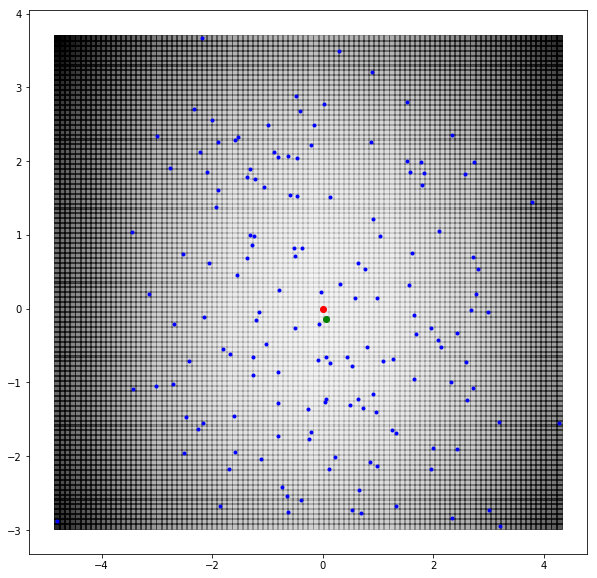

In [735]:
def minFinder(points,DEN=100):
    plt.figure(figsize=(10,10))
    plt.plot(points[:,0],points[:,1],".b")
    gx,gy = np.meshgrid(np.linspace(min(points[:,0]),max(points[:,0]),DEN),
                      np.linspace(min(points[:,1]),max(points[:,1]),DEN))
    gx,gy = gx.reshape(DEN**2),gy.reshape(DEN**2)
    dist = [sum(np.linalg.norm(points-np.array([gx[i],gy[i]]).T,axis=1)) for i in range(DEN**2)]
    plt.scatter(gx,gy,marker=",",color=[(0,0,0,(dist[i]/max(dist))**3) for i in range(DEN**2)])
    plt.plot(np.average(points[:,0]),np.average(points[:,1]),"or")
    plt.plot(gx[dist.index(min(dist))],gy[dist.index(min(dist))],"og")
minFinder(Dpoints)

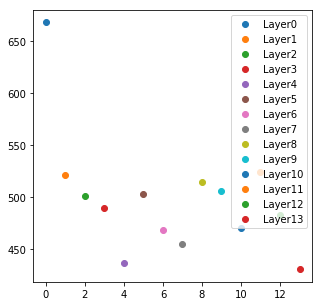

In [787]:
plt.figure(figsize=(5,5))
for layer,indexes in layerindexes.items():
    #plt.plot([layer]*len(indexes),[sum(np.linalg.norm(Dpoints-Dpoints[i],axis=1)) for i in indexes],"o",label="Layer{0}".format(layer))
    plt.plot([layer],np.average([sum(np.linalg.norm(Dpoints-Dpoints[i],axis=1)) for i in indexes]),"o",label="Layer{0}".format(layer))
plt.legend()

In [801]:
prompoint = np.array([np.average(Dpoints[:,0]),np.average(Dpoints[:,1])])
distoprom = np.linalg.norm(Dpoints-prompoint,axis=1)
totalsums = [sum(np.linalg.norm(Dpoints-Dpoints[i],axis=1)) for i in range(Dpoints.shape[0])]

In [150]:
os.listdir("/home/iampuero/Downloads")
for n in [11,21,51,101,121,151]:
    ising = loadmat("MatlabIsing/Models/E0C3T0.02N20R0P0F{0}S0.mat".format(n-1))
    params = ising["params"] # N , N*(N-1)/2
    #print(params[:,0],len(params[:,0]),N)
    P = np.zeros((n,n)) #FullMatrix for indexing
    P[np.triu_indices(n, 1)] = params[:,0][n:] #UpperTri Matrix
    H = params[:,0][:n]
    np.savetxt("/home/iampuero/Downloads/IsingParams/N{0}H.txt".format(n),H,fmt="%.5f")
    np.savetxt("/home/iampuero/Downloads/IsingParams/N{0}J.txt".format(n),P,fmt="%.5f")

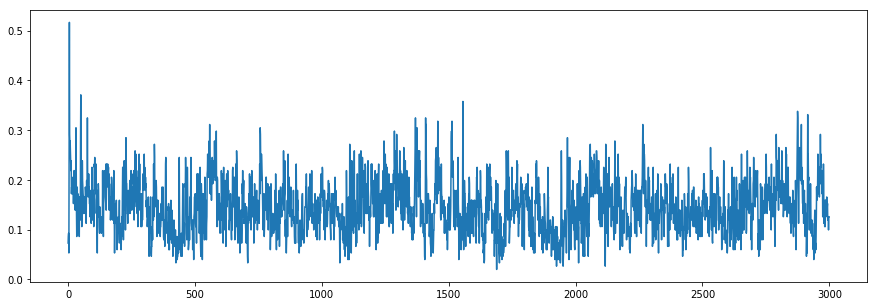

In [187]:
plt.figure(figsize=(15,5))
totalact = np.sum(RASTER,axis=0)
totsp = np.array([np.sum(data[i:i+50]) for i in range(0,T-window)])/(1/TBASE)

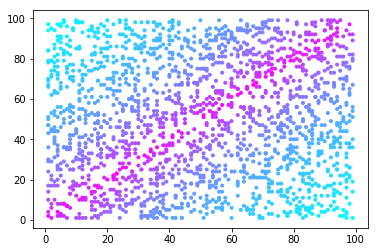

In [39]:
a = np.random.randint(1,100,2000)
b = np.random.randint(1,100,2000)
dists = np.array([np.sqrt(abs(a[n]-b[n])/np.sqrt(2)) for n in range(2000)])
dists/=max(dists)
plt.scatter(a,b,c=[[1-d,d,1] for d in dists],marker=".")

In [183]:
frequent = [a for a,b in sorted(enumerate(np.sum(raster2,axis=1)),key=lambda x:x[1],reverse=1)[:50]]

In [184]:
sum(RASTER[frequent[49]])

10223.0

In [30]:
with open("Raster1000f.txt","w") as O:
    for i in frequent:
        O.write(" ".join(map(str,np.where(RASTER[i][:1000])[0]/1000))+"\n")

In [187]:
def savePranasRaster(raster,tt,n,iid):
    frequent = [a for a,b in sorted(enumerate(np.sum(raster,axis=1)),key=lambda x:x[1],reverse=1)[:50]]
    selected = list(np.random.choice(frequent,n,replace=False))
    print(selected)
    with open("../../inria/PyDimRed/Rasters/Retina{0}N{1}T{2}.txt".format(iid,n,tt),"w") as O:
        for t in range(tt):
            for i in selected:
                if raster[i][t]==1:
                    O.write("{} {}\n".format(t,selected.index(i)))
    print("./main {} {} 0 0.1 100 RasterB{}x{}.txt Params{}x{}".format(n,tt,tt,n,tt,n))

In [189]:

print(loadedRaster.shape)
for iid in range(4):
    loadedRaster = dataLoader(iid,3,0.02)[0]
    for n in [15]:
        for t in [50000]:
            savePranasRaster(loadedRaster,t,n,iid)


(151, 61809)
Returning saved sparse matrix E0_C3_T0.02
[65, 89, 19, 138, 21, 62, 34, 93, 32, 136, 111, 43, 101, 38, 92]
./main 15 50000 0 0.1 100 RasterB50000x15.txt Params50000x15
Returning saved sparse matrix E1_C3_T0.02
[173, 105, 160, 37, 161, 77, 171, 15, 38, 162, 93, 172, 67, 153, 17]
./main 15 50000 0 0.1 100 RasterB50000x15.txt Params50000x15
Returning saved sparse matrix E2_C3_T0.02
[203, 185, 240, 11, 72, 108, 244, 213, 178, 4, 93, 243, 167, 16, 73]
./main 15 50000 0 0.1 100 RasterB50000x15.txt Params50000x15
Returning saved sparse matrix E3_C3_T0.02
[78, 116, 85, 20, 3, 42, 76, 72, 99, 125, 181, 150, 248, 216, 17]
./main 15 50000 0 0.1 100 RasterB50000x15.txt Params50000x15


In [177]:
raster2 = dataLoader(3,COND,TBASE)[0]
print(raster2.shape)

Returning saved sparse matrix E3_C3_T0.02
(270, 61805)


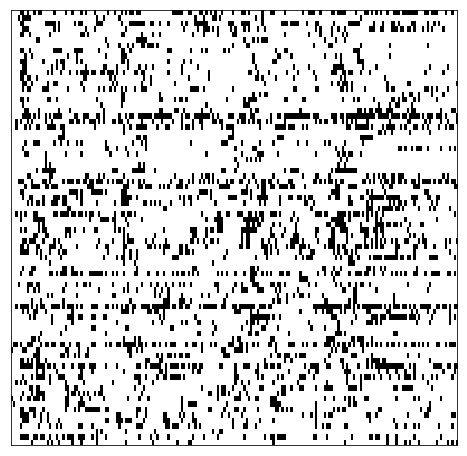

/opt/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


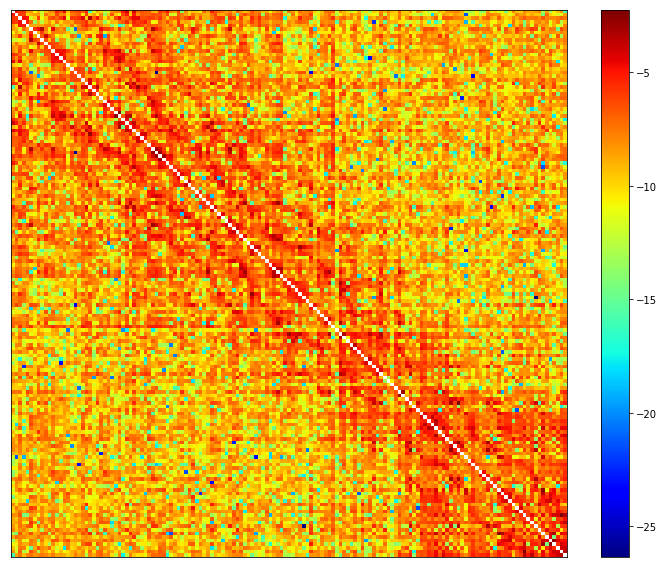

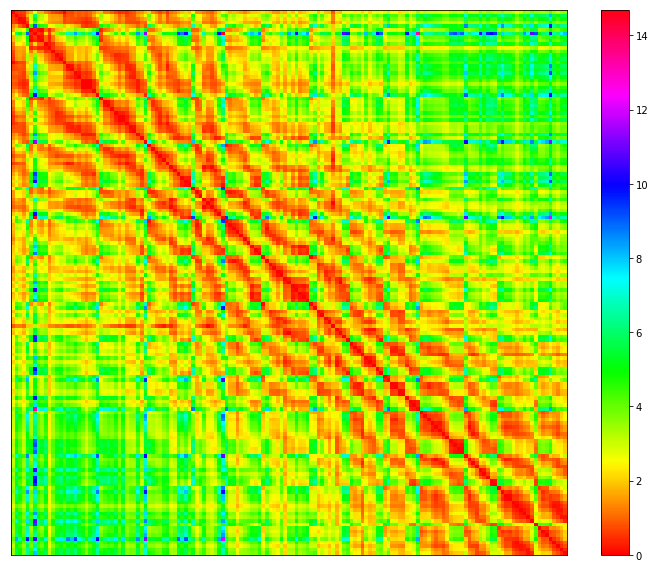

/opt/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/opt/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


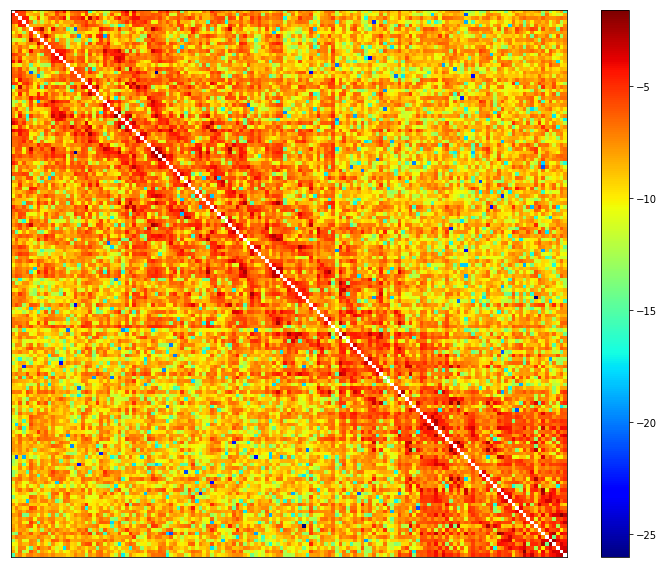

In [42]:
plt.figure(figsize=(8,8))
plt.imshow(RASTER[:80,:200]*-1,aspect="auto",cmap="gray")
plt.yticks([]);plt.xticks([])
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(np.log(MI),aspect="auto",cmap="jet")
plt.yticks([]);plt.xticks([])
plt.colorbar()
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(D,aspect="auto",cmap="hsv")
plt.yticks([]);plt.xticks([])
plt.colorbar()
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(np.log(CC),aspect="auto",cmap="jet")
plt.yticks([]);plt.xticks([])
plt.colorbar()
plt.tight_layout()
plt.show()


In [215]:
for n in range(10):
    for nn in range(15):
        print(choice("01"),end=" ")
    print()

1 1 1 1 0 1 1 0 1 0 1 0 1 0 0 
1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 
0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 
1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 
0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 
1 0 0 0 1 0 1 1 1 0 0 0 1 0 0 
0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 
0 1 1 0 0 0 1 1 0 0 1 1 1 0 1 
0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 
1 1 0 1 0 0 1 1 0 0 0 1 0 0 1 


In [131]:
RASTER = dataLoader(0,3,0.01)[0]

IndexError: invalid index to scalar variable.

In [133]:
dataLoader??

Signature: dataLoader(exp, cond, tbase)
Docstring: <no docstring>
Source:   
def dataLoader(exp,cond,tbase):
    rasterfile = "../Data/Sparse/E{0}_C{1}_T{2}".format(exp,cond,tbase)
    if os.path.isfile(rasterfile+".npz"):
        print("Returning saved sparse matrix",rasterfile.split("/")[-1])
        raster = sparse.load_npz(rasterfile+".npz")
        raster = raster.toarray()
        return raster,raster.shape[0]
    data = loadmat(FILENAME)["spks"][exp][cond][0]
    Ncount = data.shape[0] #neuron count
    maxdata = max([max(data[n][0]) for n in range(Ncount)])+1 #max spike time of sample
    raster=np.zeros((Ncount,int(maxdata/tbase)))  #raster dimensions
    for n in range(Ncount):
        for s in data[n][0]:
            if not np.isnan(s):
                raster[n][int(s/tbase)]=1 #binarizing [0,TBIN[ and so on
    print ("Saving sparse matrix")
    sparse.save_npz(rasterfile,sparse.csr_matrix(raster))
    return raster,Ncount
File:      ~/Documents/Memoria/Code/JITDWrapper.py


In [145]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict
    
    
def dataLoader(exp,cond,tbase):
    rasterfile = "../Data/Sparse/E{0}_C{1}_T{2}".format(exp,cond,tbase)
    if os.path.isfile(rasterfile+".npz"):
        print("Returning saved sparse matrix",rasterfile.split("/")[-1])
        raster = sparse.load_npz(rasterfile+".npz")
        raster = raster.toarray()
        return raster,raster.shape[0]
    data = loadmat(FILENAME)["spks"][exp][cond]
    Ncount = int(data.shape[0]) #neuron count
    #print(data,Ncount)
    maxdata = max([max(data[n]) for n in range(Ncount)])+1 #max spike time of sample
    raster=np.zeros((Ncount,int(maxdata/tbase)))  #raster dimensions
    for n in range(Ncount):
        for s in data[n]:
            if not np.isnan(s):
                raster[n][int(s/tbase)]=1 #binarizing [0,TBIN[ and so on
    print ("Saving sparse matrix")
    sparse.save_npz(rasterfile,sparse.csr_matrix(raster))
    return raster,Ncount

Saving sparse matrix


Returning saved sparse matrix E0_C3_T0.005


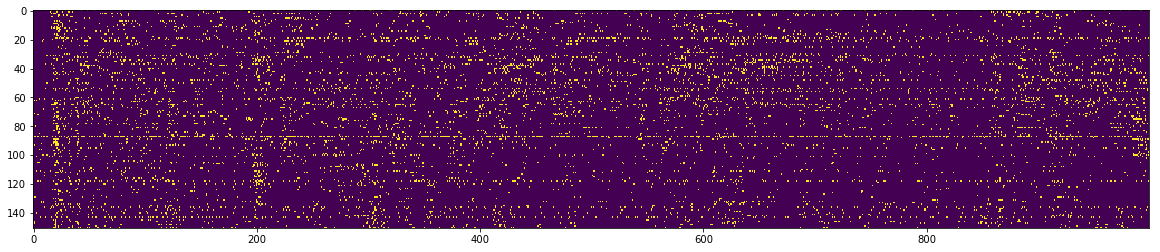

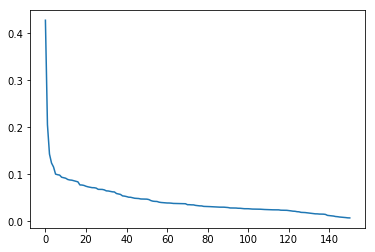

Returning saved sparse matrix E0_C3_T0.01


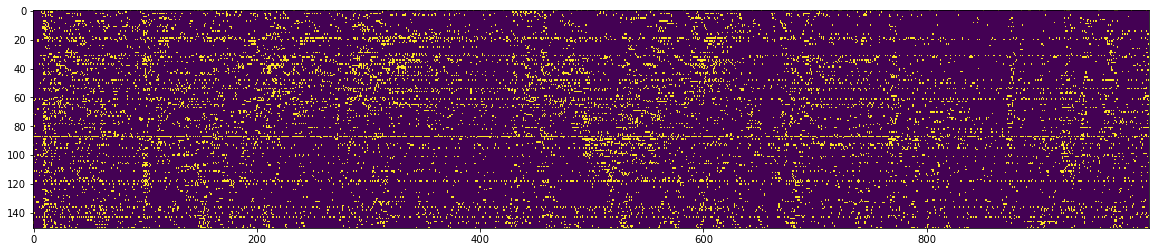

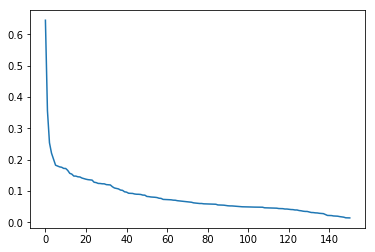

Returning saved sparse matrix E0_C3_T0.02


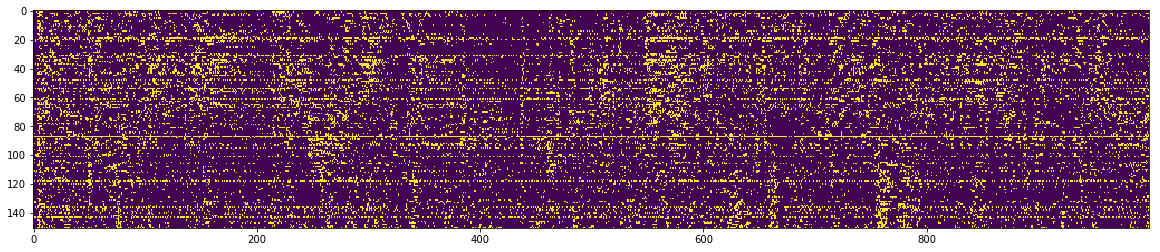

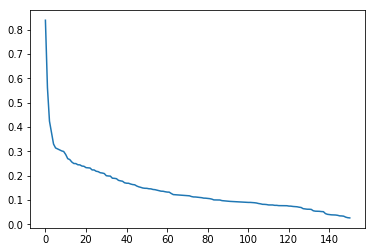

In [163]:
for tb in [0.005,0.01,0.02]:
    rast = dataLoader(0,3,tb)[0]
    plt.figure(figsize=(20,4))
    plt.imshow(rast[:,:1000],aspect="auto")
    plt.show()
    plt.plot(sorted(np.average(rast,axis=1),reverse=True))
    plt.show()


In [178]:
def savePranasRaster(raster,tt,n,iid,selected=[]):
    frequent = [a for a,b in sorted(enumerate(np.sum(raster,axis=1)),key=lambda x:x[1],reverse=1)[:50]]
    if not selected:
        selected = list(np.random.choice(frequent,n,replace=False))
    print(selected)
    with open("../../inria/MaxEntDimRed/Rasters/Retina{0}N{1}T{2}.txt".format(iid,n,tt),"w") as O:
        for t in range(tt):
            for i in selected:
                if raster[i][t]==1:
                    O.write("{} {}\n".format(t,selected.index(i)))
    print("./main {} {} 0 0.1 100 RasterB{}x{}.txt Params{}x{}".format(n,tt,tt,n,tt,n))

In [168]:
if not []:
    print(123)

123


In [181]:
savePranasRaster(dataLoader(1,3,0.01)[0],50000,15,"1_10ms",[21, 132, 187, 105, 20, 25, 91, 11, 106, 37, 45, 53, 19, 171, 156])

Saving sparse matrix
[21, 132, 187, 105, 20, 25, 91, 11, 106, 37, 45, 53, 19, 171, 156]
./main 15 50000 0 0.1 100 RasterB50000x15.txt Params50000x15


Returning saved sparse matrix E0_C3_T0.005


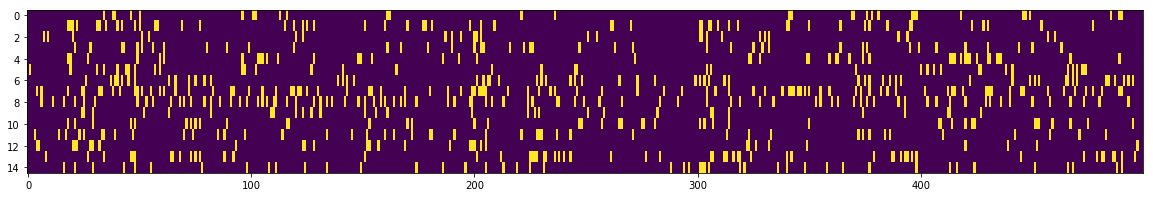

In [176]:
plt.figure(figsize=(20,3))
plt.imshow(dataLoader(0,3,0.005)[0][[21, 132, 187, 105, 20, 25, 91, 11, 106, 37, 45, 53, 19, 171, 156],:500],aspect="auto")